In [2]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

In [3]:
#updated
vals_dict = {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],
'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }

# Doing analysis for the same logit going to use the ground truth as it is a Schelling point

In [4]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [5]:
batch_size=25
num_batches=4
prompt_length=100
generated_length=150
tot_len = prompt_length+generated_length

import encoder
model_name='345M'
models_dir='../gpt-2/models'
enc = encoder.get_encoder(model_name, models_dir)

prompts=pd.read_csv('test_dataframe_500primer.csv')

In [50]:
gpt_out_path = 'gpt-2_output/'
all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))

In [7]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [6]:
tot_num = 0
for i in range(num_batches):
    print( all_logits[i].shape[0])
    tot_num+= all_logits[i].shape[0]
tot_num

23
23
24
22


92

In [7]:
all_logits[0].shape

(23, 150, 50257)

In [8]:
len(text[0][0])

250

In [9]:
#vals_dict = { 'flat':[0.01, 0.02, 0.05]  }

In [10]:
# applying all analyses to the logits. 

#real_log_probs = dict()
ground_token_in_cut = dict()
all_tail_ids = dict()
all_tail_cdfs = dict()
all_tail_perc = dict()
prompt_length = 100
for key,all_params in vals_dict.items():
    for par in all_params:
        print('key and param', key, '====', par)
        temp_tail_cdfs = np.zeros([tot_num, all_logits[0].shape[1]])
        temp_tail_ids = np.zeros([tot_num, all_logits[0].shape[1]])
        temp_tail_perc = np.zeros([tot_num, all_logits[0].shape[1]])
        p_ind = 0

        for batch in range(num_batches):
                    #for p_ind in range(batch*batch_size, (batch*batch_size)+batch_size ):
            for ind in range(0,all_logits[batch].shape[0]):
                
                if p_ind%25 == 0:
                    print('index', str(p_ind))

                ground_token_in_cut_temp = []

                for time_point in range(0,all_logits[0].shape[1]):
                    
                    ground_token = text[batch][ind][prompt_length+time_point]

                    sps = softmax(-np.sort(-all_logits[batch][ind, time_point, :]))
                    indices = np.argsort(-all_logits[batch][ind, time_point, :])
            
                    if key == 'tfs':
                        first = sps[1:] - sps[:-1]
                        second = first[1:] - first[:-1]
                        tail_id = new_tfs(second, par)
                    elif key=='flat':
                        tail_id = flat(sps, par)
                    elif key=='n':
                        tail_id = nucleus_calc(sps, par)
                    elif key=='k':
                        tail_id = par
                    else:
                        print('key not recognized')
                        break
                        
                    tail_cdf= np.sum(sps[:tail_id])
                    
                    # here we are selecting this exact index so remove the -1. 
                    tail_id = tail_id -1
                    if tail_id >= sps.shape[0]:
                        tail_id = tail_id -1
                    tail_perc = sps[tail_id]
                    
                    temp_tail_ids[p_ind, time_point] = tail_id
                    temp_tail_cdfs[p_ind, time_point] = tail_cdf
                    temp_tail_perc[p_ind, time_point] = tail_perc
                    
                    ids_above_tail = indices[:tail_id]
                    
                    ground_token_in_cut_temp.append( ground_token in ids_above_tail )
                    
                ground_token_in_cut[key+'-sampling-type_'+str(par)+'prompt_'+str(p_ind)] = ground_token_in_cut_temp
                p_ind+=1
            
        all_tail_perc[key+'-sampling-type_'+str(par)] = temp_tail_perc
        all_tail_ids[key+'-sampling-type_'+str(par)] = temp_tail_ids
        all_tail_cdfs[key+'-sampling-type_'+str(par)] = temp_tail_cdfs

key and param tfs ==== 0.25
index 0
index 25
index 50
index 75
key and param tfs ==== 0.75
index 0
index 25
index 50
index 75
key and param tfs ==== 0.9
index 0
index 25
index 50
index 75
key and param tfs ==== 0.95
index 0
index 25
index 50
index 75
key and param tfs ==== 0.99
index 0
index 25
index 50
index 75
key and param flat ==== 0.01
index 0
index 25
index 50
index 75
key and param flat ==== 0.02
index 0
index 25
index 50
index 75
key and param flat ==== 0.05
index 0
index 25
index 50
index 75
key and param n ==== 0.1
index 0
index 25
index 50
index 75
key and param n ==== 0.25
index 0
index 25
index 50
index 75
key and param n ==== 0.5
index 0
index 25
index 50
index 75
key and param n ==== 0.63
index 0
index 25
index 50
index 75
key and param n ==== 0.69
index 0
index 25
index 50
index 75
key and param n ==== 0.75
index 0
index 25
index 50
index 75
key and param n ==== 0.81
index 0
index 25
index 50
index 75
key and param n ==== 0.9
index 0
index 25
index 50
index 75
key and p

In [11]:
pickle.dump(all_tail_ids, gzip.open('Shared_GTruth_Logits_Tail_IDs_dict_Aug5.pickle', 'wb'))
pickle.dump(all_tail_cdfs, gzip.open('Shared_GTruth_Logits_Tail_CDFs_dict_Aug5.pickle', 'wb'))
pickle.dump(all_tail_perc, gzip.open('Shared_GTruth_Tail_Probs_Aug5.pickle', 'wb'))
pickle.dump(ground_token_in_cut, gzip.open('Shared_GTruth_GTruth_In_Cut_Aug5.pickle', 'wb'))


In [6]:
all_tail_ids = pickle.load(gzip.open('Shared_GTruth_Logits_Tail_IDs_dict_Aug5.pickle', 'rb'))
all_tail_cdfs = pickle.load(gzip.open('Shared_GTruth_Logits_Tail_CDFs_dict_Aug5.pickle', 'rb'))
all_tail_perc = pickle.load(gzip.open('Shared_GTruth_Tail_Probs_Aug5.pickle', 'rb'))
ground_token_in_cut=pickle.load(gzip.open('Shared_GTruth_GTruth_In_Cut_Aug5.pickle', 'rb'))

## What is the tail position for the late ones??

# Analyzing the in cut!!! 

Key is: tfs
tfs-sampling-type_0.25_prompt
tfs-sampling-type_0.75_prompt
tfs-sampling-type_0.9_prompt
tfs-sampling-type_0.95_prompt
tfs-sampling-type_0.99_prompt
Key is: flat
flat-sampling-type_0.01_prompt
flat-sampling-type_0.02_prompt
flat-sampling-type_0.05_prompt
Key is: n
n-sampling-type_0.1_prompt
n-sampling-type_0.25_prompt
n-sampling-type_0.5_prompt
n-sampling-type_0.63_prompt
n-sampling-type_0.69_prompt
n-sampling-type_0.75_prompt
n-sampling-type_0.81_prompt
n-sampling-type_0.9_prompt


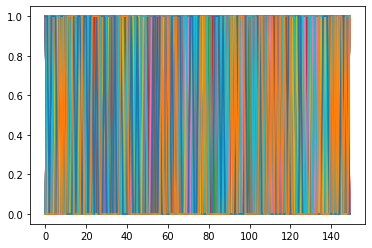

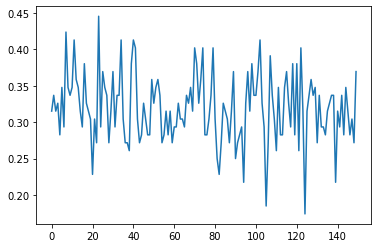

Key is: k
k-sampling-type_1_prompt


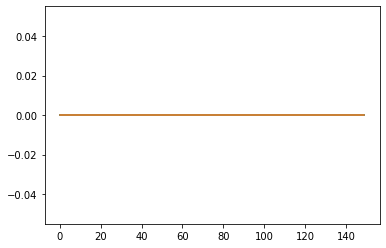

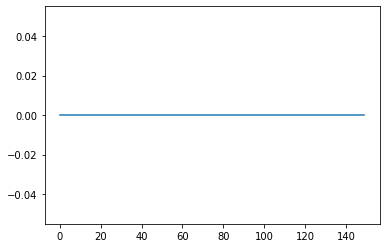

k-sampling-type_10_prompt
k-sampling-type_40_prompt
k-sampling-type_200_prompt


In [15]:
global_mean = dict()
for key, params in vals_dict.items():
    print('Key is:', key)
    for par in params:
        print(key+'-sampling-type_'+str(par)+'_prompt')
        vals_to_plot = []
        for p_ind in range(tot_num):
            try:
                vals_to_plot.append(ground_token_in_cut[key+'-sampling-type_'+str(par)+'prompt_'+str(p_ind)])
            except:
                pass
                #print('couldnt load in as not here.')
        vals_to_plot = np.asarray(vals_to_plot)
        
        if key == "k" and str(par)=='1':
            plt.plot(vals_to_plot.T)
            plt.show()
            plt.plot(vals_to_plot.mean(axis=0))
            plt.show()
            
        if key == "n" and str(par)=='0.9':
            plt.plot(vals_to_plot.T)
            plt.show()
            plt.plot(vals_to_plot.mean(axis=0))
            plt.show()
        
        global_mean[key+'-sampling-type_'+str(par)+'_prompt'] = (vals_to_plot.mean(), (1.96*(vals_to_plot.std()/np.sqrt(vals_to_plot.shape[0]))))
        print('=======')

In [16]:
means =[]
errors = []
names = []
for k, v in global_mean.items():
    means.append(v[0])
    errors.append(v[1])
    names.append(k.split('-')[0]+'_'+k.split('_')[-2])

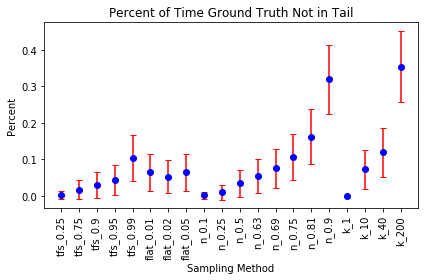

In [17]:
x_pos = np.arange(len(means))
plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Percent')
plt.xlabel('Sampling Method')
plt.xticks(rotation=90)
plt.title('Percent of Time Ground Truth Not in Tail')
plt.tight_layout()
plt.show()

## Flattening

In [7]:
# need to have them all compete against each other to see what is the highest in each of the positions. 

very_first = True

#vals_dict = {'n': [0.1, 0.25, 0.5, 0.75, 0.9], 'k':[1,10,40,200]  } #'tfs':[None, 0.01, 0.05, 0.1, 0.5, 0.75 ]

for key, params in vals_dict.items():
    print('Key is:', key)
    for par in params:
        
        flat_ids = all_tail_ids[key+'-sampling-type_'+str(par)].flatten()
        flat_cdfs = all_tail_cdfs[key+'-sampling-type_'+str(par)].flatten()
        flat_perc = all_tail_perc[key+'-sampling-type_'+str(par)].flatten()

        if very_first ==True:

            tail_id_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_ids})
            tail_cdf_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_cdfs})
            tail_perc_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_perc})
            very_first=False

        else:

            tail_id_df[key+'-sampling-type_'+str(par)] = flat_ids
            tail_cdf_df[key+'-sampling-type_'+str(par)] = flat_cdfs
            tail_perc_df[key+'-sampling-type_'+str(par)] = flat_perc
        

Key is: tfs
Key is: flat
Key is: n
Key is: k


## Analyzing the percentage that the cut is made at. 

In [10]:
tail_perc_df.shape

(13800, 20)

In [11]:
means = tail_perc_df.mean(axis=0)
errors = (1.96*(tail_perc_df.std(axis=0)/np.sqrt(tail_perc_df.shape[0])))
names = tail_perc_df.columns.tolist()

In [12]:
errors

tfs-sampling-type_0.25     0.004436
tfs-sampling-type_0.75     0.004868
tfs-sampling-type_0.9      0.004757
tfs-sampling-type_0.95     0.004316
tfs-sampling-type_0.99     0.002709
flat-sampling-type_0.01    0.000029
flat-sampling-type_0.02    0.000068
flat-sampling-type_0.05    0.000220
n-sampling-type_0.1        0.004392
n-sampling-type_0.25       0.004743
n-sampling-type_0.5        0.005132
n-sampling-type_0.63       0.005012
n-sampling-type_0.69       0.004869
n-sampling-type_0.75       0.004653
n-sampling-type_0.81       0.004350
n-sampling-type_0.9        0.003634
k-sampling-type_1          0.004336
k-sampling-type_10         0.000107
k-sampling-type_40         0.000022
k-sampling-type_200        0.000004
dtype: float64

## The mean is tight but is it appropriate?!?!

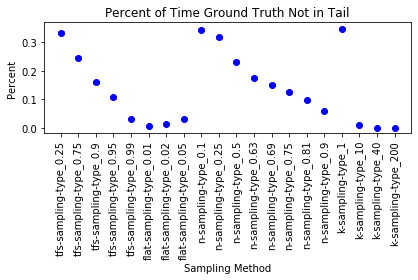

In [13]:
x_pos = np.arange(len(means))
plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Percent')
plt.xlabel('Sampling Method')
plt.xticks(rotation=90)
plt.title('Percent of Time Ground Truth Not in Tail')
plt.tight_layout()
plt.show()

In [14]:
median =tail_perc_df.median(axis=0)
median;

In [15]:

upper = np.percentile(tail_perc_df, 95, axis=0)
lower = np.percentile(tail_perc_df, 5, axis=0)

dist = pd.DataFrame({'median':median, 'upper':upper,'lower': lower, 'gap':upper-lower})

Can see that the TFS method has a wide range of different prob thresholds used. 

In [16]:
dist.sort_values('gap')

,median,upper,lower,gap
k-sampling-type_200,0.000208,0.000708,0.000010,0.000697
k-sampling-type_40,0.001839,0.004231,0.000109,0.004122
flat-sampling-type_0.01,0.009146,0.009938,0.004943,0.004996
flat-sampling-type_0.02,0.017181,0.019781,0.007090,0.012691
k-sampling-type_10,0.010811,0.021973,0.000837,0.021136
tfs-sampling-type_0.99,0.002414,0.024669,0.000472,0.024197
flat-sampling-type_0.05,0.036611,0.048876,0.001690,0.047186
k-sampling-type_1,0.270118,0.910701,0.054993,0.855708
tfs-sampling-type_0.25,0.245521,0.910701,0.045232,0.865468
n-sampling-type_0.1,0.270118,0.910701,0.032945,0.877756


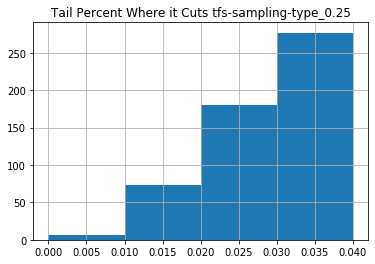

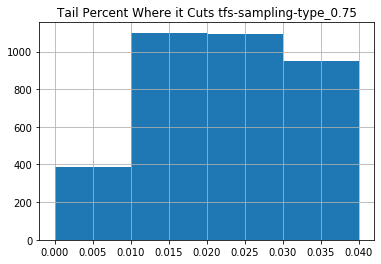

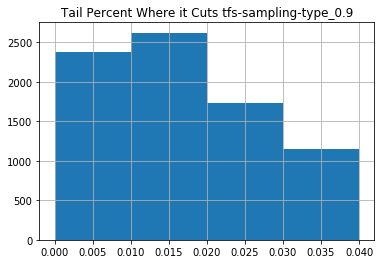

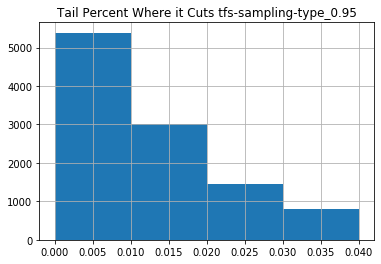

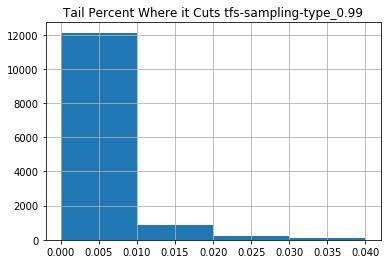

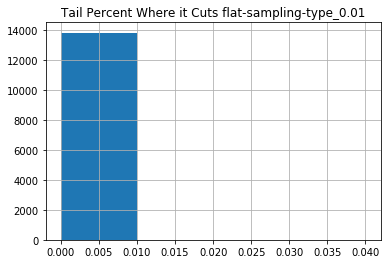

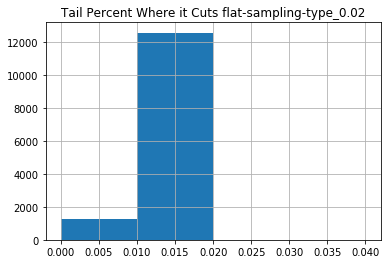

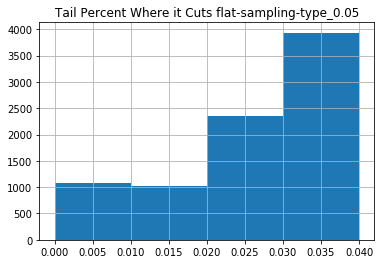

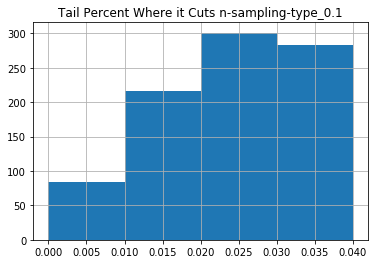

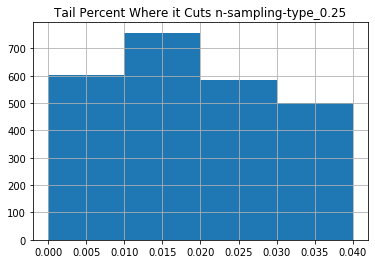

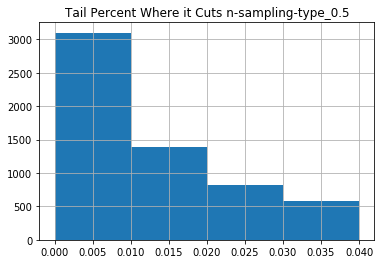

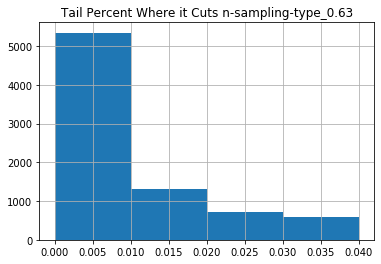

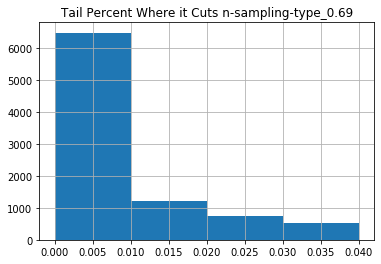

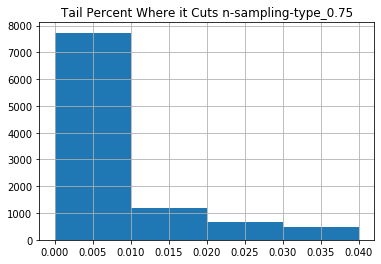

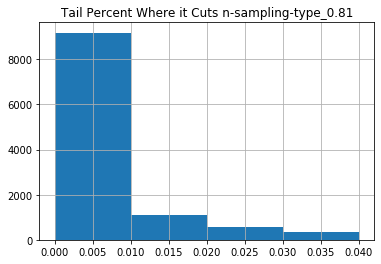

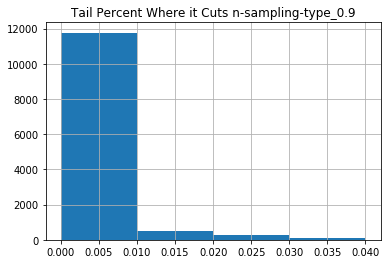

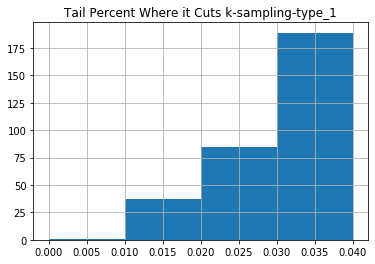

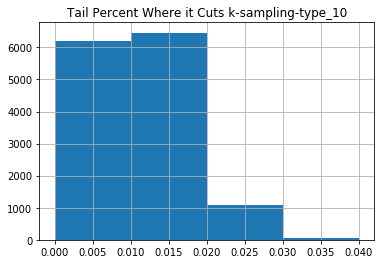

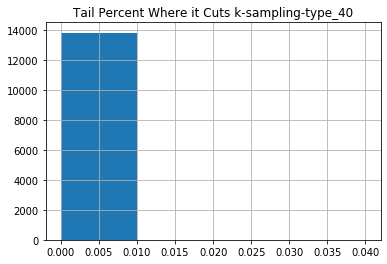

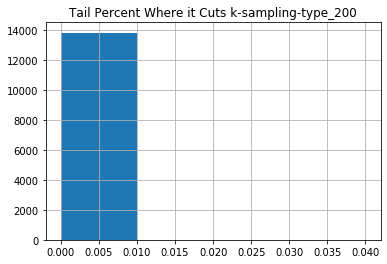

In [17]:
for c in tail_perc_df.columns: 
    
    tail_perc_df[c].hist(bins=np.arange(0,0.05,0.01))#100)
    plt.title('Tail Percent Where it Cuts '+c)
    plt.show()

# Doing the same but for the tail ID

In [18]:
tail_id_df.shape

(13800, 20)

In [19]:
means = tail_id_df.mean(axis=0)
errors = (1.96*(tail_id_df.std(axis=0)/np.sqrt(tail_id_df.shape[0])))
names = tail_id_df.columns.tolist()

In [20]:
errors

tfs-sampling-type_0.25       0.011864
tfs-sampling-type_0.75       0.067972
tfs-sampling-type_0.9        0.202158
tfs-sampling-type_0.95       0.425462
tfs-sampling-type_0.99       1.942598
flat-sampling-type_0.01      7.136819
flat-sampling-type_0.02     43.936406
flat-sampling-type_0.05    162.587041
n-sampling-type_0.1          0.016054
n-sampling-type_0.25         0.090214
n-sampling-type_0.5          0.589834
n-sampling-type_0.63         1.412109
n-sampling-type_0.69         2.132049
n-sampling-type_0.75         3.285428
n-sampling-type_0.81         5.263895
n-sampling-type_0.9         12.523937
k-sampling-type_1            0.000000
k-sampling-type_10           0.000000
k-sampling-type_40           0.000000
k-sampling-type_200          0.000000
dtype: float64

## The mean is tight but is it appropriate?!?!

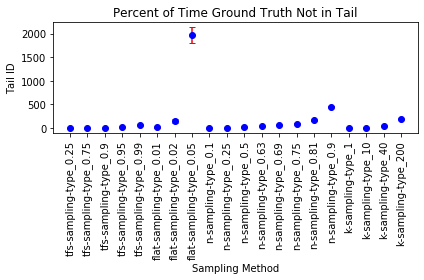

In [21]:
x_pos = np.arange(len(means))
plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Tail ID')
plt.xlabel('Sampling Method')
plt.xticks(rotation=90)
plt.title('Percent of Time Ground Truth Not in Tail')
plt.tight_layout()
plt.show()

In [22]:
median =tail_id_df.median(axis=0)
median;

In [23]:

upper = np.percentile(tail_id_df, 95, axis=0)
lower = np.percentile(tail_id_df, 5, axis=0)

dist = pd.DataFrame({'median':median, 'upper':upper,'lower': lower, 'gap':upper-lower})

# TFS is tighter here on the same distributions, therefore it seems to have a lower variance

In [24]:
dist.sort_values('gap')

,median,upper,lower,gap
k-sampling-type_200,199.0,199.00,199.0,0.00
k-sampling-type_10,9.0,9.00,9.0,0.00
k-sampling-type_1,0.0,0.00,0.0,0.00
k-sampling-type_40,39.0,39.00,39.0,0.00
n-sampling-type_0.1,0.0,2.00,0.0,2.00
tfs-sampling-type_0.25,0.0,2.00,0.0,2.00
flat-sampling-type_0.05,3.0,6.00,1.0,5.00
flat-sampling-type_0.02,6.0,10.00,1.0,9.00
n-sampling-type_0.25,0.0,10.00,0.0,10.00
tfs-sampling-type_0.75,2.0,11.00,0.0,11.00


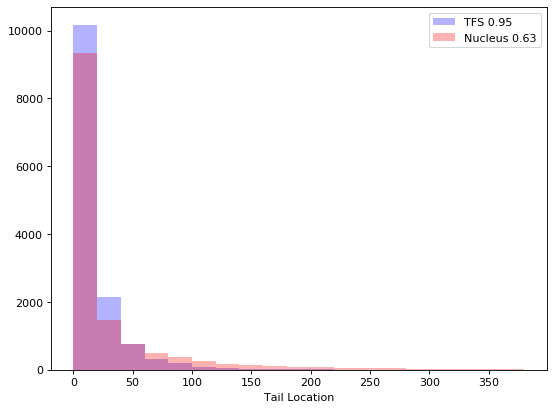

In [25]:
bins = range(0,400, 20)#20
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(tail_id_df['tfs-sampling-type_0.95'], 
         color='blue', alpha=0.3, bins=bins, label='TFS 0.95')
plt.hist(tail_id_df['n-sampling-type_0.63' ], 
         color='red', alpha=0.3, bins=bins, label='Nucleus 0.63')
plt.legend()
plt.xlabel('Tail Location')
plt.show()

In [27]:
np.corrcoef(tail_id_df['tfs-sampling-type_0.95'],tail_id_df['n-sampling-type_0.63' ])

array([[1.        , 0.67660705],
       [0.67660705, 1.        ]])

In [33]:
tail_id_df['tfs-sampling-type_0.95'].max()

604.0

tfs-sampling-type_0.95 vs n-sampling-type_0.69


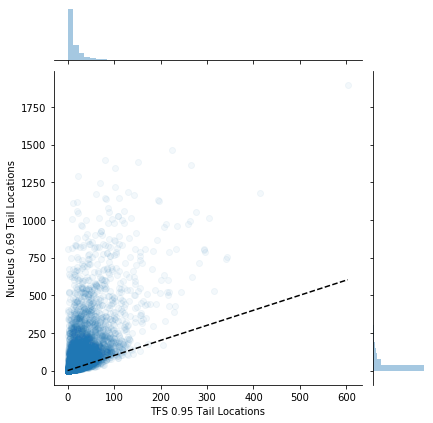

In [28]:
# also more of a fair comparison. 
import seaborn as sns
tfs_label = 'tfs-sampling-type_0.95'
nuc_label = 'n-sampling-type_0.69'

#sns.set(style="white", color_codes=True)
print(tfs_label+ ' vs '+nuc_label)
graph = sns.jointplot(tail_id_df[tfs_label], 
            tail_id_df[nuc_label], kind='scatter', 
              annot_kws=None, 
              alpha=0.05).set_axis_labels('TFS 0.95 Tail Locations', 
                                          'Nucleus 0.69 Tail Locations')
diag = np.arange(tail_id_df['tfs-sampling-type_0.95'].max())

graph.x = diag
graph.y = diag
#graph.plot_joint(plt.scatter, marker='x', c='b', s=50)
graph.plot_joint(plt.plot, color='black', linestyle='--')
plt.gcf().savefig('ImageOutputs/TFS_nineFive_vs_Nuc_sixNine_ID_Plot.png', dpi=250)
#plt.plot(diag, diag, color='black', linestyle='--')
plt.show()

tfs-sampling-type_0.95 vs n-sampling-type_0.69


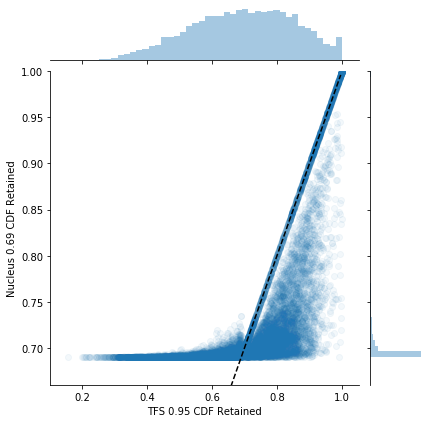

In [29]:
# also more of a fair comparison. 
import seaborn as sns
tfs_label = 'tfs-sampling-type_0.95'
nuc_label = 'n-sampling-type_0.69'

#sns.set(style="white", color_codes=True)
print(tfs_label+ ' vs '+nuc_label)
graph = sns.jointplot(tail_cdf_df[tfs_label], 
            tail_cdf_df[nuc_label], kind='scatter', 
              annot_kws=None, 
              alpha=0.05).set_axis_labels('TFS 0.95 CDF Retained', 
                                          'Nucleus 0.69 CDF Retained')
diag = np.arange(tail_cdf_df[tfs_label].min(),tail_cdf_df[tfs_label].max(),0.01)

graph.x = diag
graph.y = diag
#graph.plot_joint(plt.scatter, marker='x', c='b', s=50)
graph.plot_joint(plt.plot, color='black', linestyle='--')
plt.ylim([tail_cdf_df[nuc_label ].min()-0.03, 1.0])
#plt.plot(diag, diag, color='black', linestyle='--')
plt.gcf().savefig('ImageOutputs/TFS_nineFive_vs_Nuc_sixNine_CDF_Plot.png', dpi=250)
plt.show()

In [30]:
def findHowManyOnEachSide(x, y):
    print('equal', sum(x ==  y)/x.shape[0])
    print('first less than second', sum(x <  y)/x.shape[0])
    print('first greater than second', sum(x >  y)/x.shape[0])
    

In [31]:
findHowManyOnEachSide(tail_id_df[tfs_label],tail_id_df[nuc_label])

equal 0.14746376811594203
first less than second 0.4753623188405797
first greater than second 0.37717391304347825


tfs-sampling-type_0.99 vs n-sampling-type_0.81


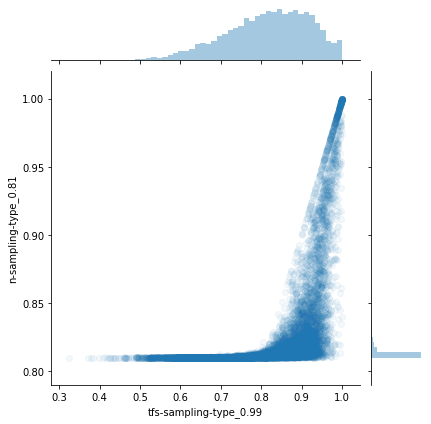

In [33]:
tfs_label = 'tfs-sampling-type_0.99'
nuc_label = 'n-sampling-type_0.81'

#sns.set(style="white", color_codes=True)
print(tfs_label+ ' vs '+nuc_label)
sns.jointplot(tail_cdf_df[tfs_label], 
            tail_cdf_df[nuc_label], kind='scatter', 
              annot_kws=None, 
              alpha=0.05).set_axis_labels(tfs_label, 
                                          nuc_label)

plt.show()

tfs-sampling-type_0.9 vs n-sampling-type_0.63


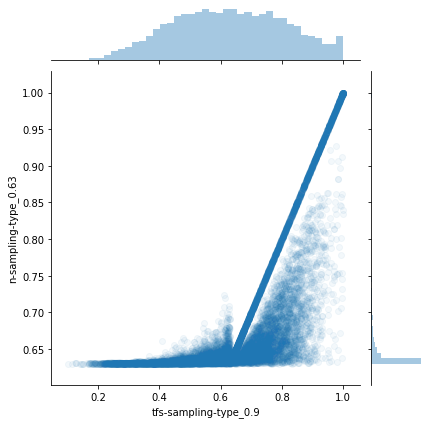

In [36]:
# this one is the weakest comparison

tfs_label = 'tfs-sampling-type_0.9'
nuc_label = 'n-sampling-type_0.63'

#sns.set(style="white", color_codes=True)
print(tfs_label+ ' vs '+nuc_label)
sns.jointplot(tail_cdf_df[tfs_label], 
            tail_cdf_df[nuc_label], kind='scatter', 
              annot_kws=None, 
              alpha=0.05).set_axis_labels(tfs_label, 
                                          nuc_label)

plt.show()

In [74]:
tail_cdf_df['tfs-sampling-type_0.95'].shape[0]

13800

In [75]:
findHowManyOnEachSide(tail_cdf_df['tfs-sampling-type_0.95'],tail_cdf_df['n-sampling-type_0.63'])

equal 0.13384057971014493
first less than second 0.3458695652173913
first greater than second 0.5202898550724637


## What is the correlation between these? Or some other difference metric? 

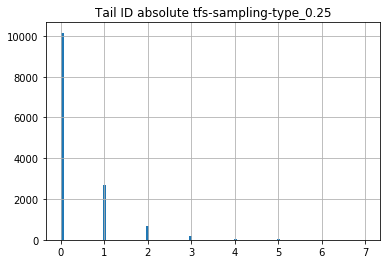

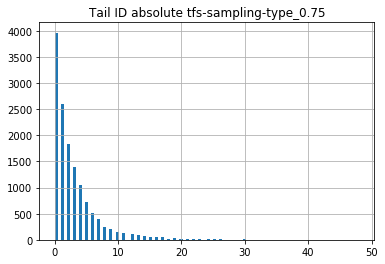

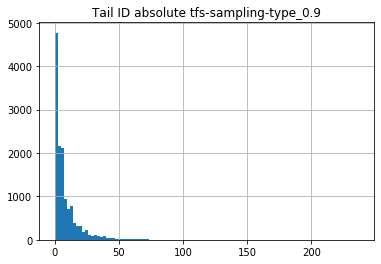

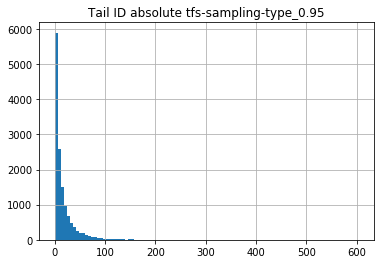

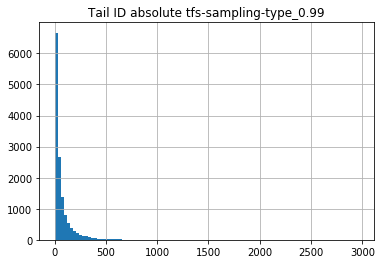

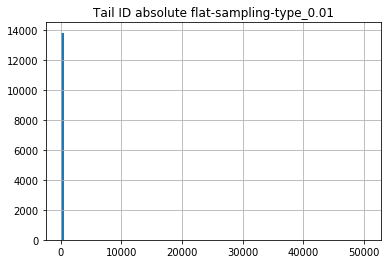

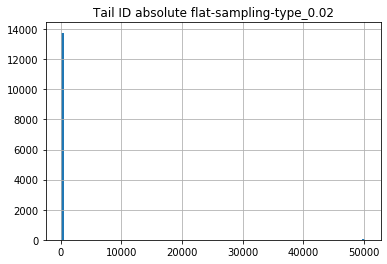

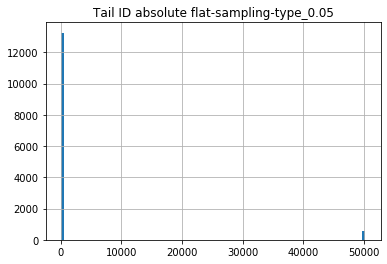

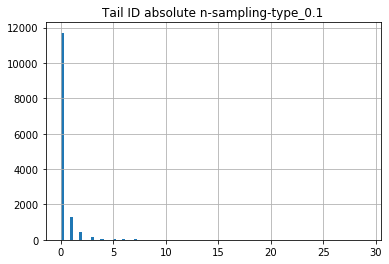

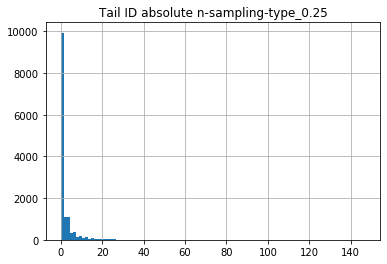

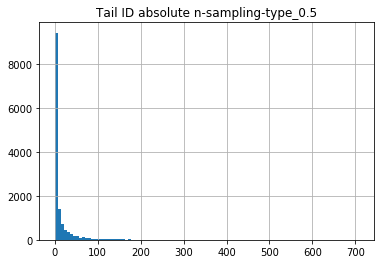

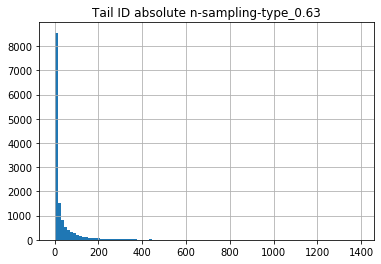

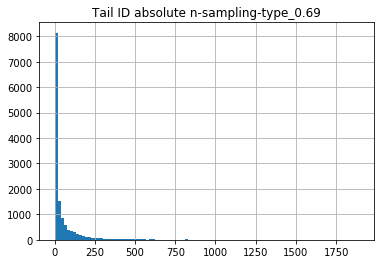

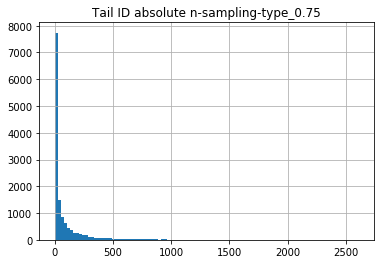

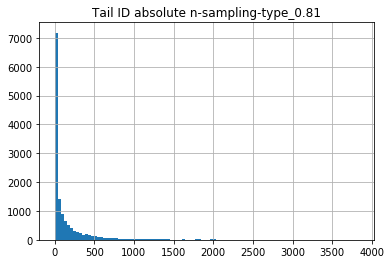

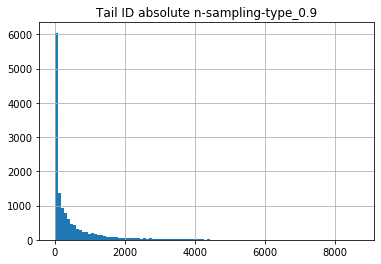

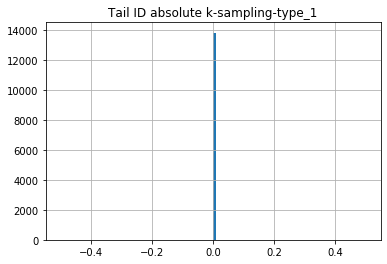

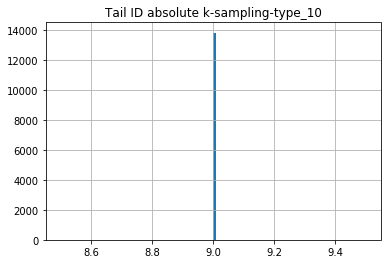

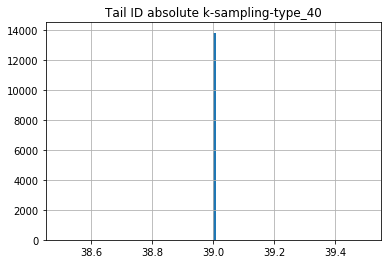

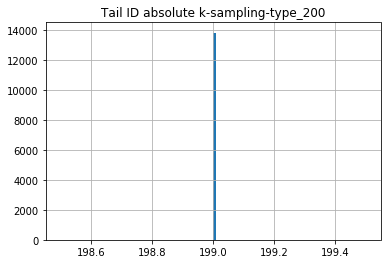

In [24]:
for c in tail_id_df.columns: 
    
    tail_id_df[c].hist(bins=100)
    plt.title('Tail ID absolute '+c)
    plt.show()

In [84]:
means =[]
errors = []
names = []
for k, v in global_mean.items():
    means.append(v[0])
    errors.append(v[1])
    names.append(k.split('-')[0]+'_'+k.split('_')[-2])

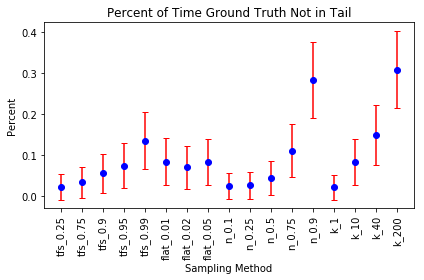

In [86]:
x_pos = np.arange(len(means))
plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Percent')
plt.xlabel('Sampling Method')
plt.xticks(rotation=90)
plt.title('Percent of Time Ground Truth Not in Tail')
plt.tight_layout()
plt.show()

In [11]:
tail_id_df.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,1.0,6.0,32.0,68.0,323.0,10.0,3.0,50256.0,2.0,14.0,84.0,477.0,1837.0,0.0,9.0,39.0,199.0
1,1.0,7.0,11.0,18.0,79.0,13.0,11.0,4.0,0.0,2.0,9.0,92.0,765.0,0.0,9.0,39.0,199.0
2,0.0,1.0,9.0,32.0,190.0,9.0,2.0,1.0,1.0,14.0,91.0,442.0,1532.0,0.0,9.0,39.0,199.0
3,2.0,7.0,21.0,34.0,104.0,15.0,8.0,5.0,1.0,3.0,10.0,68.0,588.0,0.0,9.0,39.0,199.0
4,0.0,0.0,3.0,5.0,29.0,10.0,6.0,4.0,0.0,0.0,3.0,35.0,213.0,0.0,9.0,39.0,199.0


In [12]:
tail_cdf_df.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,0.088069,0.180100,0.359715,0.467853,0.698734,0.221990,0.130383,1.000001,0.111883,0.257670,0.500762,0.750125,0.900007,0.048363,0.212049,0.385776,0.630231
1,0.195709,0.458126,0.544737,0.605920,0.738505,0.564211,0.544737,0.358047,0.104595,0.253911,0.504213,0.750648,0.900043,0.104595,0.504213,0.682153,0.808859
2,0.083045,0.105751,0.217192,0.345367,0.621967,0.217192,0.125647,0.105751,0.105751,0.254137,0.500359,0.750154,0.900025,0.083045,0.217192,0.370212,0.629212
3,0.249014,0.459610,0.626024,0.684609,0.788215,0.575046,0.477050,0.408154,0.177891,0.317482,0.508798,0.750977,0.900033,0.098499,0.493339,0.698797,0.835927
4,0.348137,0.348137,0.533203,0.582694,0.733283,0.651578,0.599475,0.560987,0.348137,0.348137,0.533203,0.751377,0.900178,0.348137,0.641860,0.762084,0.896196


In [13]:
tail_id_df.shape

(13800, 17)

In [14]:
tail_id_df.iloc[0].values

array([1.0000e+00, 6.0000e+00, 3.2000e+01, 6.8000e+01, 3.2300e+02,
       1.0000e+01, 3.0000e+00, 5.0256e+04, 2.0000e+00, 1.4000e+01,
       8.4000e+01, 4.7700e+02, 1.8370e+03, 0.0000e+00, 9.0000e+00,
       3.9000e+01, 1.9900e+02])

In [44]:
np.argsort(tail_id_df.iloc[0,:].values)

array([13,  0,  8,  6,  1, 14,  5,  9,  2, 15,  3, 10, 16,  4, 11, 12,  7])

In [46]:
tail_id_df_ranking = tail_id_df.rank(axis=0, method='average')  # lowest

In [47]:
tail_id_df_ranking.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,11503.0,11808.5,13171.5,13228.5,13315.5,6763.0,2385.0,13530.5,13224.5,13397.5,13291.5,13152.0,12971.0,6900.5,6900.5,6900.5,6900.5
1,11503.0,12260.5,10529.0,9904.0,10305.0,9891.5,13358.5,10709.5,5855.0,10489.0,9788.0,10412.5,11168.0,6900.5,6900.5,6900.5,6900.5
2,5079.5,5268.5,9758.0,11760.0,12557.0,5680.5,1235.0,1347.0,12362.0,13397.5,13341.0,13079.0,12673.0,6900.5,6900.5,6900.5,6900.5
3,13190.0,12260.5,12447.5,11932.0,11148.5,11522.0,10975.0,12346.0,12362.0,11386.0,10007.5,9754.5,10520.5,6900.5,6900.5,6900.5,6900.5
4,5079.5,1983.0,5364.5,4934.0,6598.5,6763.0,7607.0,10709.5,5855.0,3676.5,7124.5,8308.5,7849.5,6900.5,6900.5,6900.5,6900.5


In [48]:
tail_cdf_df.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,0.088069,0.180100,0.359715,0.467853,0.698734,0.221990,0.130383,1.000001,0.111883,0.257670,0.500762,0.750125,0.900007,0.048363,0.212049,0.385776,0.630231
1,0.195709,0.458126,0.544737,0.605920,0.738505,0.564211,0.544737,0.358047,0.104595,0.253911,0.504213,0.750648,0.900043,0.104595,0.504213,0.682153,0.808859
2,0.083045,0.105751,0.217192,0.345367,0.621967,0.217192,0.125647,0.105751,0.105751,0.254137,0.500359,0.750154,0.900025,0.083045,0.217192,0.370212,0.629212
3,0.249014,0.459610,0.626024,0.684609,0.788215,0.575046,0.477050,0.408154,0.177891,0.317482,0.508798,0.750977,0.900033,0.098499,0.493339,0.698797,0.835927
4,0.348137,0.348137,0.533203,0.582694,0.733283,0.651578,0.599475,0.560987,0.348137,0.348137,0.533203,0.751377,0.900178,0.348137,0.641860,0.762084,0.896196


In [49]:
tail_id_df.shape

(13800, 17)

In [52]:
tail_id_df.shape

(13800, 17)

In [53]:
tail_id_df.rank(axis=1, method='average').iloc[0].max() 

17.0

## Tail ID plot

In [ ]:
for c in tail_id_df.columns: 
    
    tail_id_df[c].hist(bins=100)
    plt.title('Tail ID absolute '+c)
    plt.show()

In [54]:
tail_id_df_ranking = tail_id_df.rank(axis=1, method='dense')  # lowest

In [55]:
tail_id_df_ranking.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,2.0,5.0,9.0,11.0,14.0,7.0,4.0,17.0,3.0,8.0,12.0,15.0,16.0,1.0,6.0,10.0,13.0
1,2.0,5.0,7.0,9.0,11.0,8.0,7.0,4.0,1.0,3.0,6.0,12.0,14.0,1.0,6.0,10.0,13.0
2,1.0,2.0,4.0,6.0,9.0,4.0,3.0,2.0,2.0,5.0,8.0,11.0,12.0,1.0,4.0,7.0,10.0
3,3.0,6.0,11.0,12.0,15.0,10.0,7.0,5.0,2.0,4.0,9.0,14.0,17.0,1.0,8.0,13.0,16.0
4,1.0,1.0,2.0,4.0,8.0,7.0,5.0,3.0,1.0,1.0,2.0,9.0,12.0,1.0,6.0,10.0,11.0


In [56]:
tail_cdf_df_ranking = tail_cdf_df.rank(axis=1, method='dense')
tail_cdf_df_ranking.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,2.0,5.0,9.0,11.0,14.0,7.0,4.0,17.0,3.0,8.0,12.0,15.0,16.0,1.0,6.0,10.0,13.0
1,2.0,5.0,7.0,9.0,11.0,8.0,7.0,4.0,1.0,3.0,6.0,12.0,14.0,1.0,6.0,10.0,13.0
2,1.0,2.0,4.0,6.0,9.0,4.0,3.0,2.0,2.0,5.0,8.0,11.0,12.0,1.0,4.0,7.0,10.0
3,3.0,6.0,11.0,12.0,15.0,10.0,7.0,5.0,2.0,4.0,9.0,14.0,17.0,1.0,8.0,13.0,16.0
4,1.0,1.0,2.0,4.0,8.0,7.0,5.0,3.0,1.0,1.0,2.0,9.0,12.0,1.0,6.0,10.0,11.0


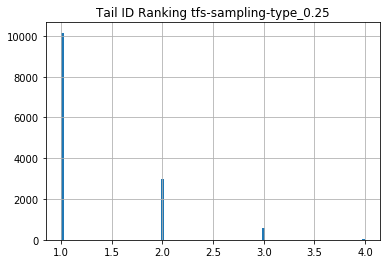

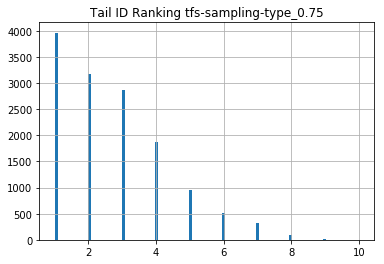

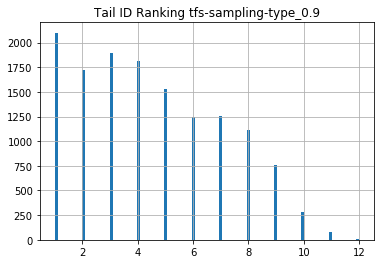

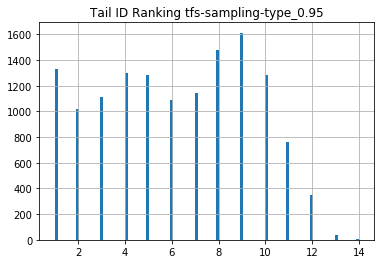

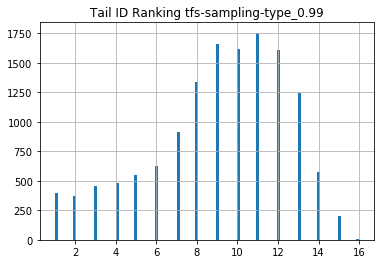

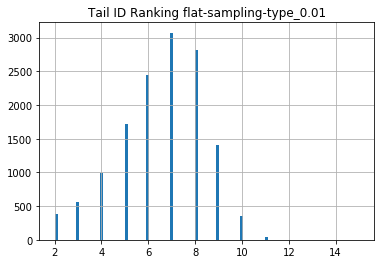

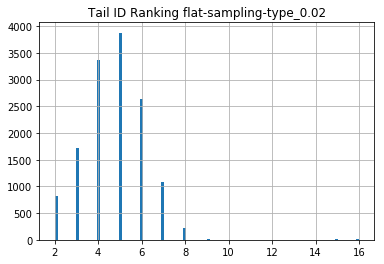

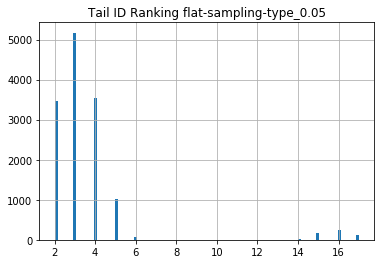

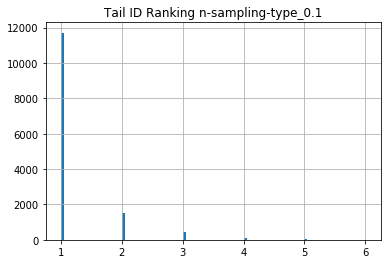

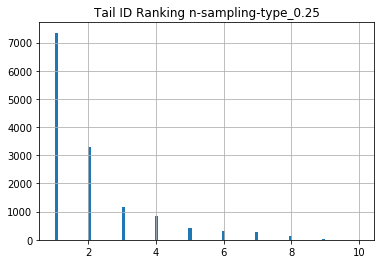

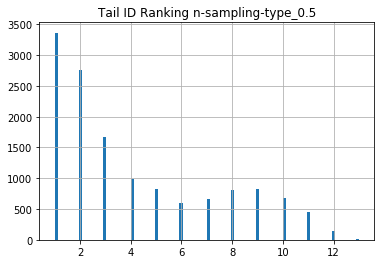

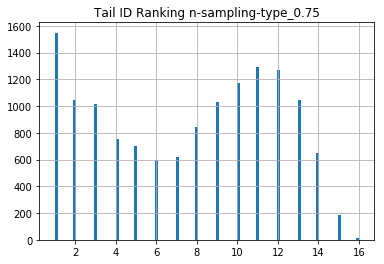

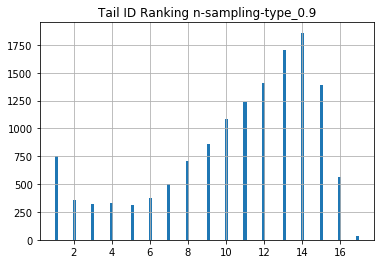

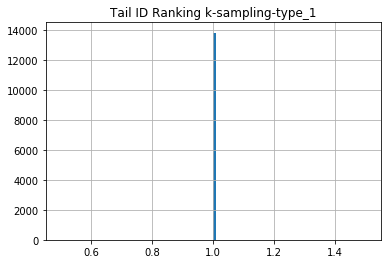

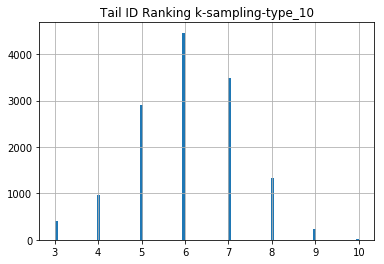

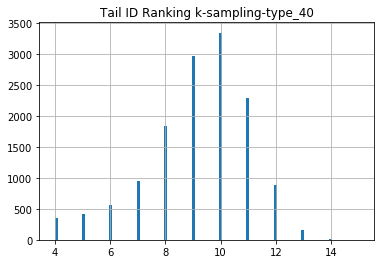

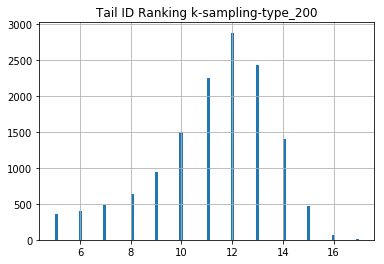

In [57]:
for c in tail_id_df_ranking.columns: 
    
    tail_id_df_ranking[c].hist(bins=100)
    plt.title('Tail ID Ranking '+c)
    plt.show()

In [58]:
tfs_n_cols = []
for c in tail_id_df.columns:
    if 'tfs-' in c or 'n-' in c:
        tfs_n_cols.append(c)

In [59]:
tfs_n_cols

['tfs-sampling-type_0.25',
 'tfs-sampling-type_0.75',
 'tfs-sampling-type_0.9',
 'tfs-sampling-type_0.95',
 'tfs-sampling-type_0.99',
 'n-sampling-type_0.1',
 'n-sampling-type_0.25',
 'n-sampling-type_0.5',
 'n-sampling-type_0.75',
 'n-sampling-type_0.9']

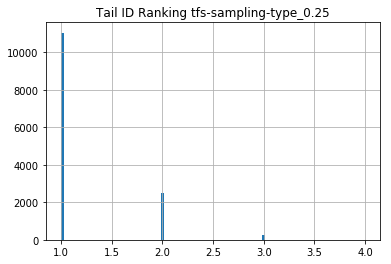

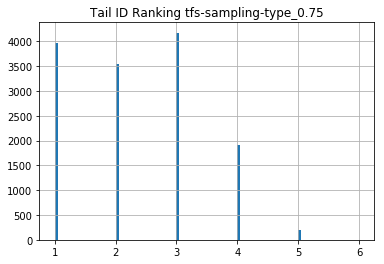

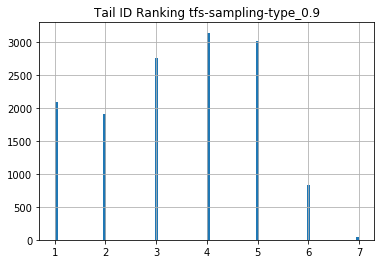

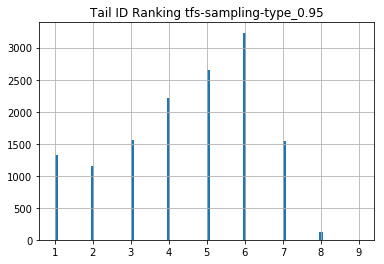

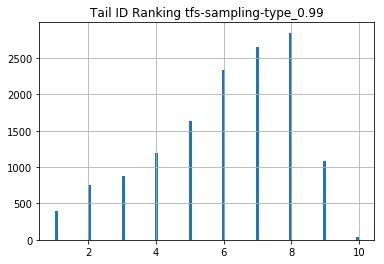

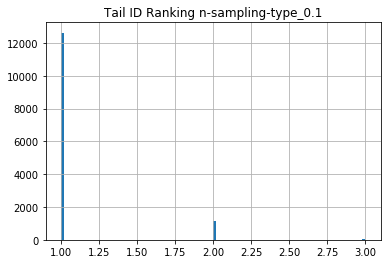

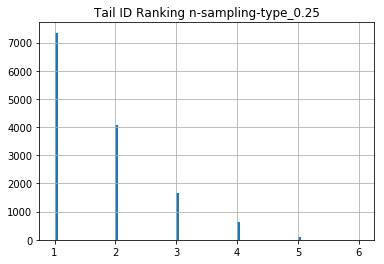

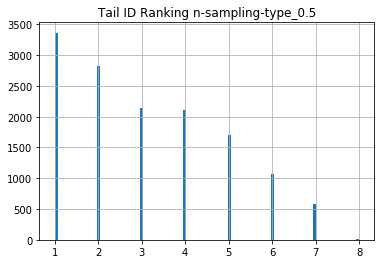

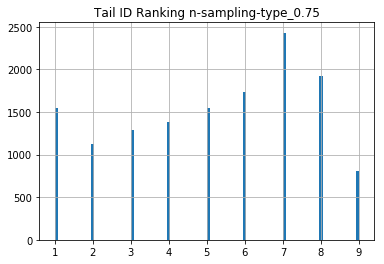

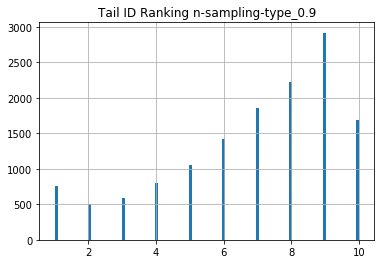

In [60]:
# only for tfs and n
temp_rank = tail_id_df[tfs_n_cols].rank(axis=1, method='dense')
for c in temp_rank.columns: 

    temp_rank[c].hist(bins=100)
    plt.title('Tail ID Ranking '+c)
    plt.show()

In [61]:
tail_cdf_df.head()

,tfs-sampling-type_0.25,tfs-sampling-type_0.75,tfs-sampling-type_0.9,tfs-sampling-type_0.95,tfs-sampling-type_0.99,flat-sampling-type_0.01,flat-sampling-type_0.02,flat-sampling-type_0.05,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200
0,0.088069,0.180100,0.359715,0.467853,0.698734,0.221990,0.130383,1.000001,0.111883,0.257670,0.500762,0.750125,0.900007,0.048363,0.212049,0.385776,0.630231
1,0.195709,0.458126,0.544737,0.605920,0.738505,0.564211,0.544737,0.358047,0.104595,0.253911,0.504213,0.750648,0.900043,0.104595,0.504213,0.682153,0.808859
2,0.083045,0.105751,0.217192,0.345367,0.621967,0.217192,0.125647,0.105751,0.105751,0.254137,0.500359,0.750154,0.900025,0.083045,0.217192,0.370212,0.629212
3,0.249014,0.459610,0.626024,0.684609,0.788215,0.575046,0.477050,0.408154,0.177891,0.317482,0.508798,0.750977,0.900033,0.098499,0.493339,0.698797,0.835927
4,0.348137,0.348137,0.533203,0.582694,0.733283,0.651578,0.599475,0.560987,0.348137,0.348137,0.533203,0.751377,0.900178,0.348137,0.641860,0.762084,0.896196


In [62]:
tail_cdf_df.shape

(13800, 17)

In [63]:
tail_cdf_df['tfs-sampling-type_0.25'].describe()

count    13800.000000
mean         0.385216
std          0.252241
min          0.017238
25%          0.183415
50%          0.319980
75%          0.536045
max          0.999969
Name: tfs-sampling-type_0.25, dtype: float64

In [64]:
(tail_cdf_df['n-sampling-type_0.5']<0.5).sum()

0

In [67]:
tail_cdf_df['n-sampling-type_0.5'].shape

(13800,)

# a tight TFS cant force the text to be degenerate here.

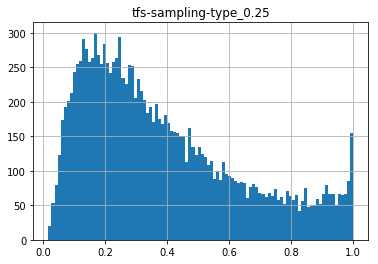

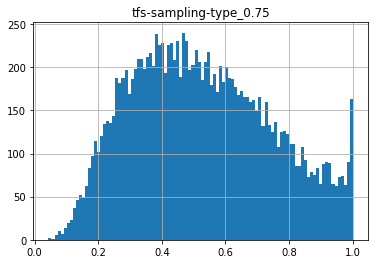

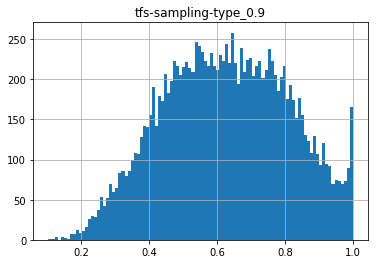

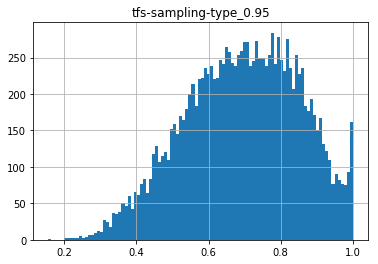

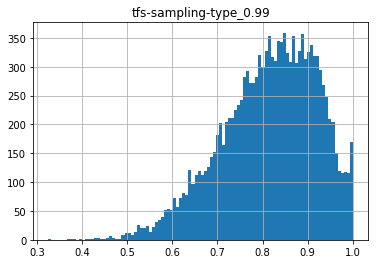

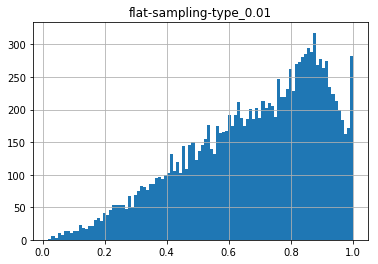

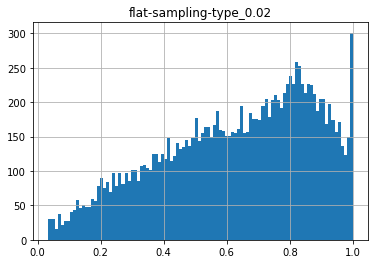

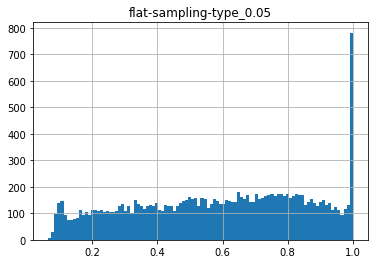

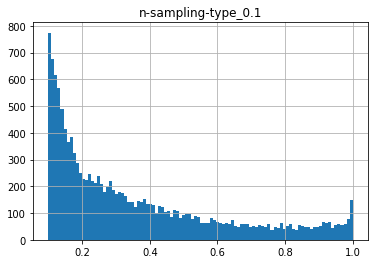

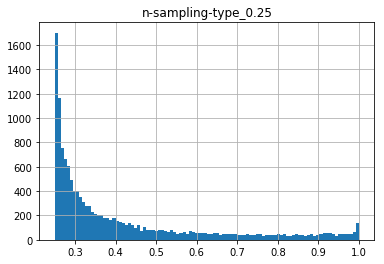

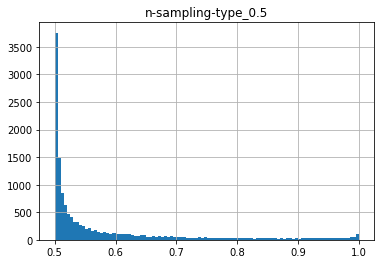

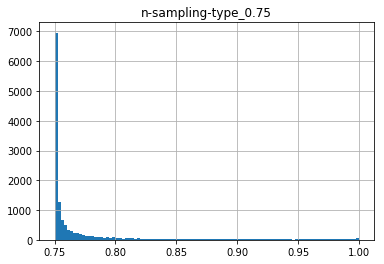

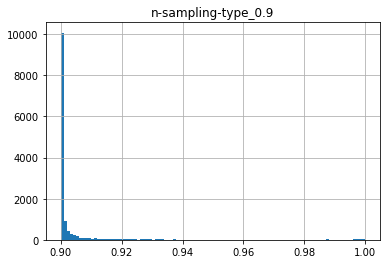

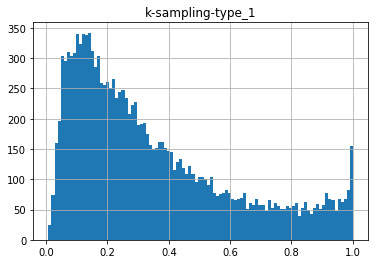

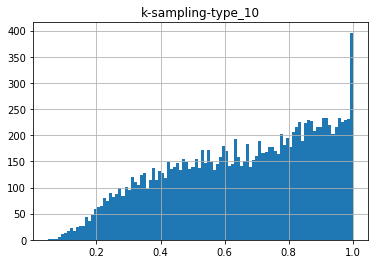

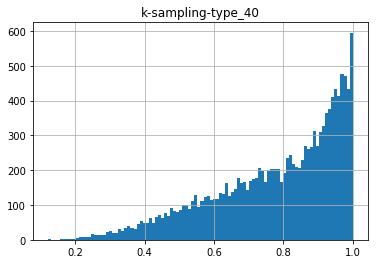

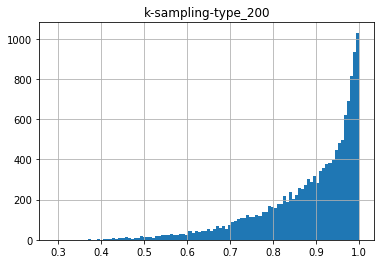

In [65]:
for c in tail_cdf_df.columns: 
    
    tail_cdf_df[c].hist(bins=100)
    plt.title(c)
    plt.show()

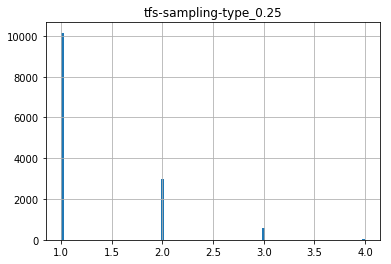

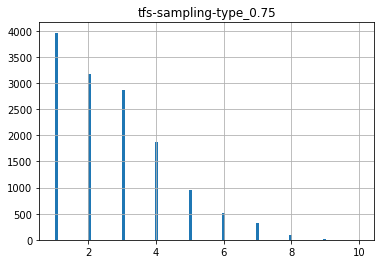

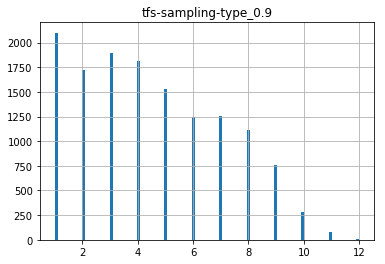

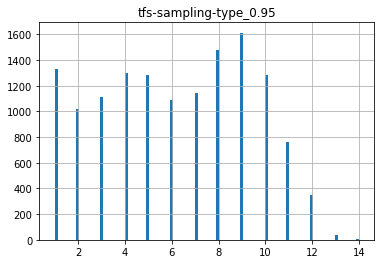

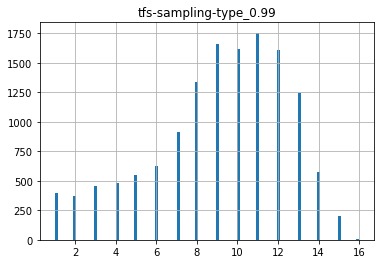

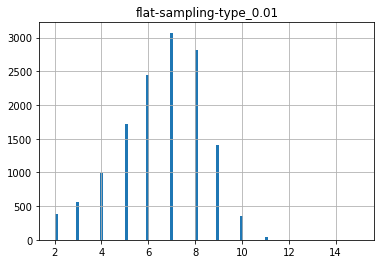

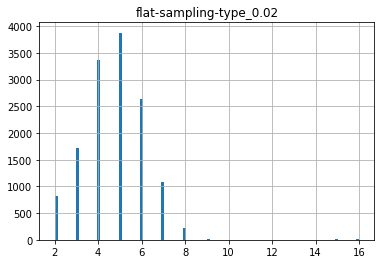

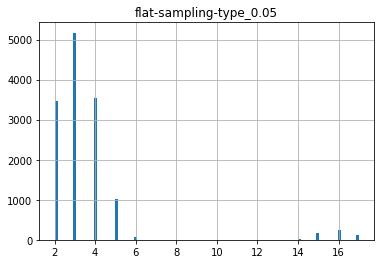

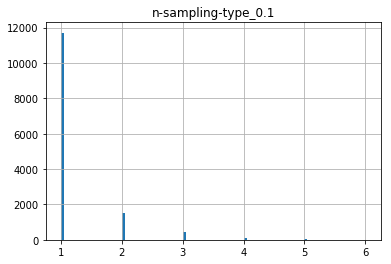

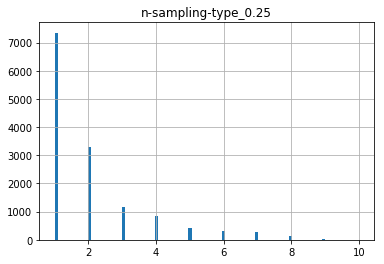

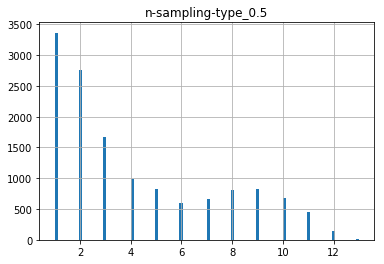

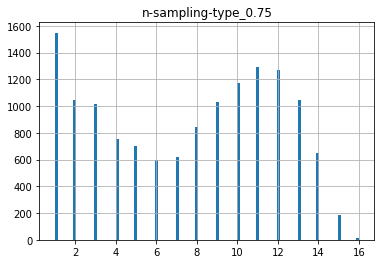

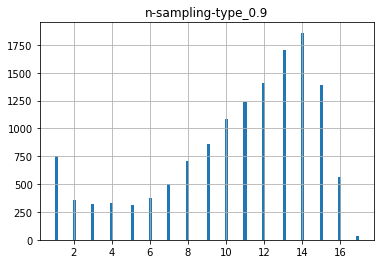

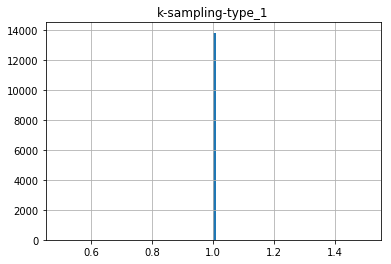

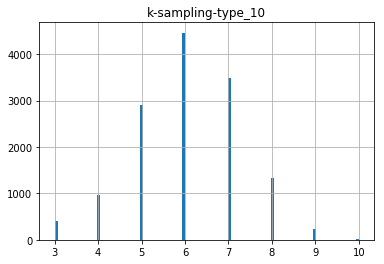

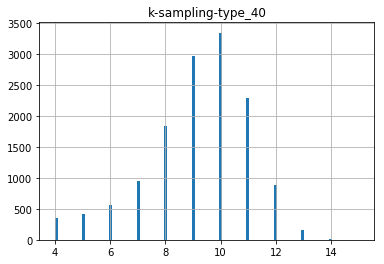

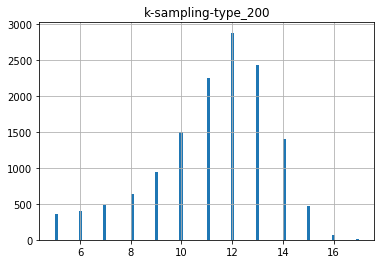

In [66]:
for c in tail_cdf_df_ranking.columns: 
    
    tail_cdf_df_ranking[c].hist(bins=100)
    plt.title(c)
    plt.show()

# Plots overlaying on the same

In [69]:
tail_cdf_df.columns

Index(['tfs-sampling-type_0.25', 'tfs-sampling-type_0.75',
       'tfs-sampling-type_0.9', 'tfs-sampling-type_0.95',
       'tfs-sampling-type_0.99', 'flat-sampling-type_0.01',
       'flat-sampling-type_0.02', 'flat-sampling-type_0.05',
       'n-sampling-type_0.1', 'n-sampling-type_0.25', 'n-sampling-type_0.5',
       'n-sampling-type_0.75', 'n-sampling-type_0.9', 'k-sampling-type_1',
       'k-sampling-type_10', 'k-sampling-type_40', 'k-sampling-type_200'],
      dtype='object')

means tfs-sampling-type_0.25 0.38521552009723975
means tfs-sampling-type_0.75 0.5273208494905545
means tfs-sampling-type_0.9 0.6270806287639383
means tfs-sampling-type_0.95 0.6936244105871605
means tfs-sampling-type_0.99 0.814361142889745


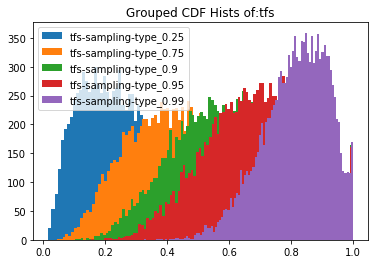

means flat-sampling-type_0.01 0.6815323084260783
means flat-sampling-type_0.02 0.6294829401619516
means flat-sampling-type_0.05 0.5890150323601953


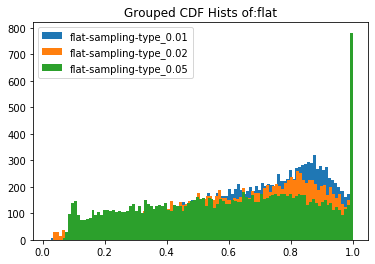

means n-sampling-type_0.1 0.35670132402492605
means n-sampling-type_0.25 0.41949074525979985
means n-sampling-type_0.5 0.5840031712642615
means n-sampling-type_0.63 0.6804124579092731
means n-sampling-type_0.69 0.7272730685230614
means n-sampling-type_0.75 0.7756079091844351
means n-sampling-type_0.81 0.8258603974788086
means n-sampling-type_0.9 0.9050873081969179


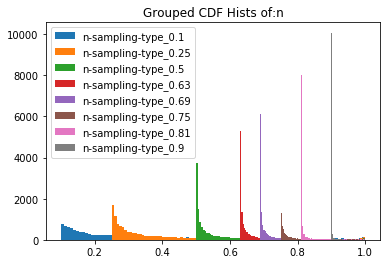

means k-sampling-type_1 0.34710718046570116
means k-sampling-type_10 0.6557619222391234
means k-sampling-type_40 0.7788094035725015
means k-sampling-type_200 0.8820645534257958


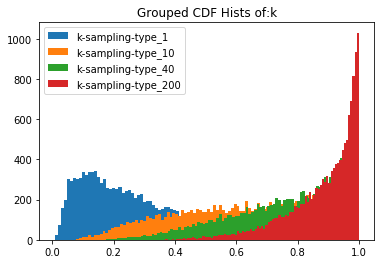

In [8]:
for k in vals_dict.keys():
    same_key_cols = []
    for c in tail_cdf_df.columns:
        if k+'-' in c:
            
            same_key_cols.append(c)
    for c in same_key_cols:
        plt.hist(tail_cdf_df[c], bins=100, alpha=1, label=c)
        print('means', c, tail_cdf_df[c].mean())
        #print('medians', c, tail_cdf_df[c].median())
    plt.title('Grouped CDF Hists of:'+k)
    plt.legend()
    plt.show()

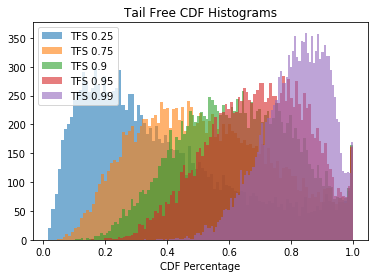

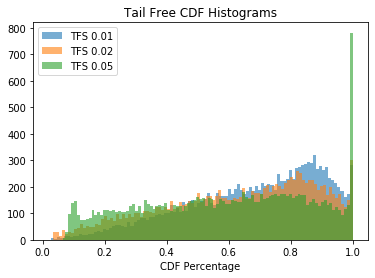

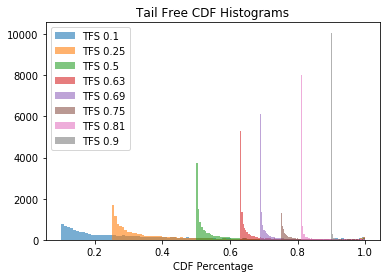

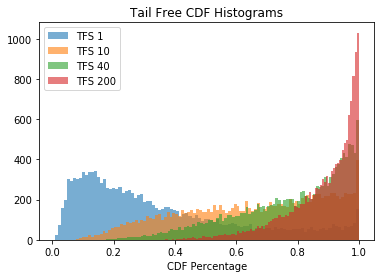

In [16]:
for k in vals_dict.keys():
    same_key_cols = []
    for c in tail_cdf_df.columns:
        if k+'-' in c:
            
            same_key_cols.append(c)
    for c in same_key_cols:
        plt.hist(tail_cdf_df[c], bins=100, alpha=0.6, label='TFS '+c.split('_')[-1])
    plt.title('Tail Free CDF Histograms')#+k)
    plt.xlabel('CDF Percentage')
    plt.legend(loc='upper left')
    if 'tfs' == k:
        plt.gcf().savefig('ImageOutputs/TFS_multi_cdf_in_body_hists.png', dpi=250)
    plt.show()

# Investigating the Samplings
## In particular find cases where the TFS is much looser or tighter than otherwise. Need to do this where the same distribution is shared for each of them. 

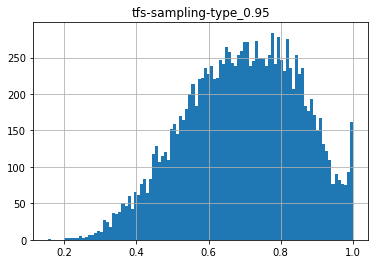

In [39]:
c = 'tfs-sampling-type_0.95'
tail_cdf_df[c].hist(bins=100)
plt.title(c)
plt.show()

# Looking at the top min and max first

In [40]:
vals_dict

{'tfs': [0.25, 0.75, 0.9, 0.95, 0.99],
 'flat': [0.01, 0.02, 0.05],
 'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9],
 'k': [1, 10, 40, 200]}

In [42]:
tfs_type = 'tfs-sampling-type_0.95'
nuc_type = 'n-sampling-type_0.69'
tail_cdf_df[tfs_type].min()

0.1559430956840515

In [43]:
tail_cdf_df[tfs_type].iloc[7690]

0.1559430956840515

In [44]:
tail_cdf_df[tfs_type][tail_cdf_df[tfs_type]<0.4]

2        0.345367
118      0.357661
194      0.363438
209      0.379711
283      0.333905
332      0.393364
566      0.312040
567      0.311002
572      0.397371
577      0.275156
578      0.355224
580      0.389819
581      0.384440
601      0.399514
616      0.383303
635      0.378382
652      0.378293
676      0.385910
750      0.364105
752      0.368731
774      0.347622
793      0.354217
803      0.393874
804      0.313933
856      0.347661
868      0.358913
870      0.289215
901      0.394620
912      0.353996
936      0.376624
           ...   
13034    0.396531
13054    0.385604
13056    0.379483
13063    0.394146
13080    0.391082
13082    0.351513
13083    0.358285
13090    0.296719
13092    0.337257
13096    0.389070
13105    0.303386
13114    0.340060
13119    0.378748
13145    0.344604
13355    0.290904
13358    0.365904
13360    0.362166
13379    0.365769
13394    0.393649
13401    0.385266
13466    0.371627
13485    0.370227
13501    0.331723
13520    0.383502
13553    0

In [45]:
when getting the max ones sum 
up the nuc values withteh tfs values and 
get hte smallest ones that are thereforehte best for both

SyntaxError: invalid syntax (<ipython-input-45-1f45128658a2>, line 1)

In [46]:
min_example_inds = tail_cdf_df.sort_values(tfs_type, ascending=True)[tfs_type].head(10).index


In [47]:
#tail_cdf_df['temp_sum'] = tail_cdf_df[tfs_type]+tail_cdf_df[nuc_type]
mask = tail_cdf_df[nuc_type]<np.percentile(tail_cdf_df[nuc_type], 10)
max_example_inds = tail_cdf_df[mask].sort_values(tfs_type, ascending=False)[tfs_type].head(10).index



In [48]:
tail_cdf_df.iloc[2950];

In [63]:
'TFS '+str(par)+' | CDF='+str(round(np.sum(sps[:tail_id]),2))

'TFS 0.95 | CDF=0.16'

In [68]:
example_ind

0

In [69]:
min_or_max

Int64Index([7690, 1539, 7714, 1647, 2887, 7502, 10833, 6014, 7542, 9476], dtype='int64')

In [67]:
'Example: '+str(example_ind)+'TFS: '+min_or_max + ' | Token Probability Distribution'

TypeError: can only perform ops with scalar values

Min or Max?? Min
example number 0
cdf looking for: 0.1559430956840515
Time Point: 40
tfs tail id is:  10
tail id is: 10
nucleus tail at: 0.69 1007
timepoint 40
cdf is 0.1559431
10 words before are: � d sung this term of worship to their sterile


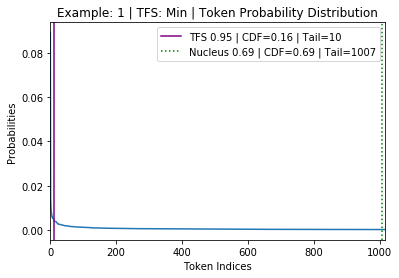

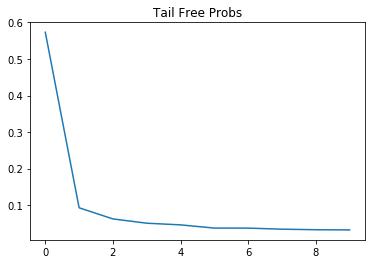

example number 1
cdf looking for: 0.20035520195960999
Time Point: 39
tfs tail id is:  17
tail id is: 17
nucleus tail at: 0.69 832
timepoint 39
cdf is 0.2003552
10 words before are:  Mothers are no longer people, merely backgrounds for jokes


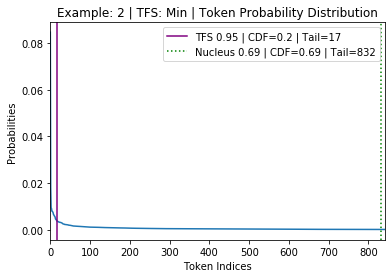

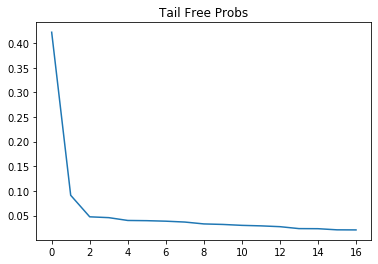

example number 2
cdf looking for: 0.20410999655723572
Time Point: 64
tfs tail id is:  41
tail id is: 41
nucleus tail at: 0.69 997
timepoint 64
cdf is 0.20411
10 words before are:  nothing more than feigned modesty—an expression of


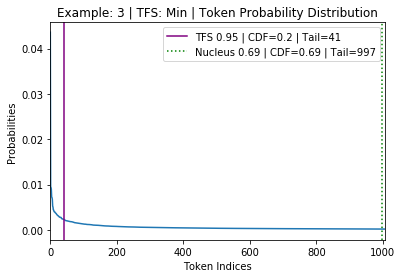

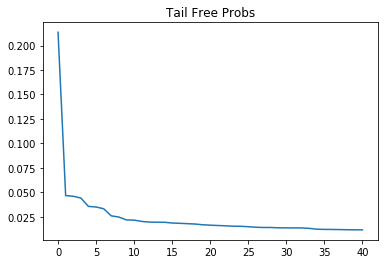

example number 3
cdf looking for: 0.20606252551078796
Time Point: 147
tfs tail id is:  23
tail id is: 23
nucleus tail at: 0.69 1291
timepoint 147
cdf is 0.20606253
10 words before are: , in between the wars and money-making ventures


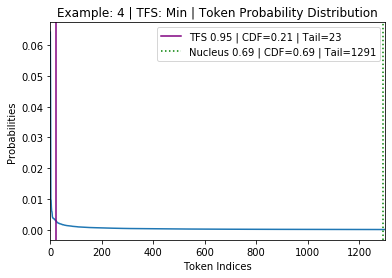

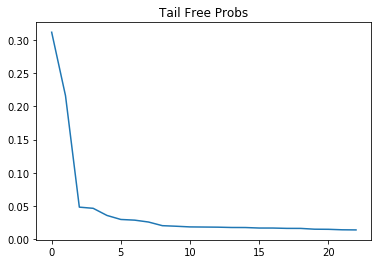

example number 4
cdf looking for: 0.21023018658161163
Time Point: 37
tfs tail id is:  11
tail id is: 11
nucleus tail at: 0.69 619
timepoint 37
cdf is 0.21023019
10 words before are:  chain of events. He was alone, surrounded by


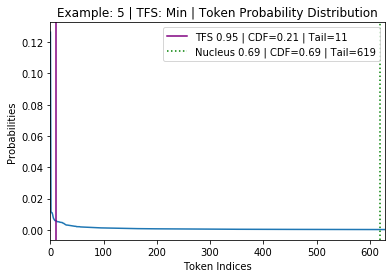

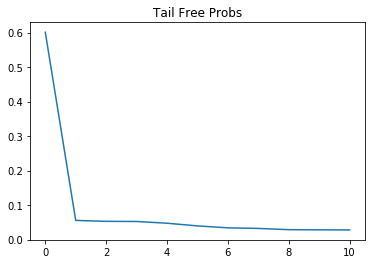

example number 5
cdf looking for: 0.21201536059379578
Time Point: 2
tfs tail id is:  16
tail id is: 16
nucleus tail at: 0.69 637
timepoint 2
cdf is 0.21201536
10 words before are:  failing to wake up in the morning due to a


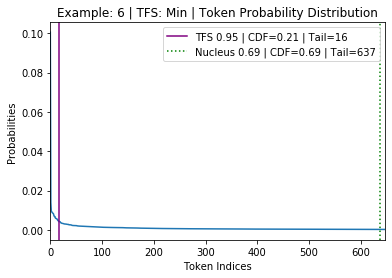

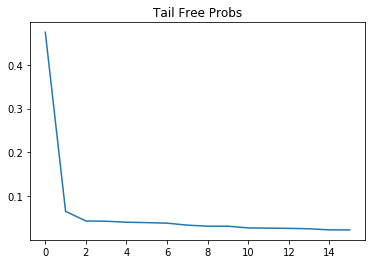

example number 6
cdf looking for: 0.21243524551391602
Time Point: 33
tfs tail id is:  1
tail id is: 1
nucleus tail at: 0.69 807
timepoint 33
cdf is 0.21243525
10 words before are: 
 There was a long and complicated paper trail of


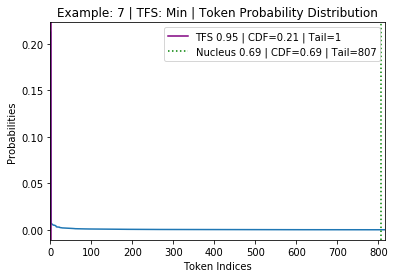

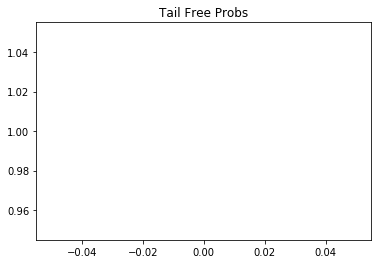

example number 7
cdf looking for: 0.21706253290176392
Time Point: 14
tfs tail id is:  27
tail id is: 27
nucleus tail at: 0.69 514
timepoint 14
cdf is 0.21706253
10 words before are:  child's broken plaything, risen with evil intent


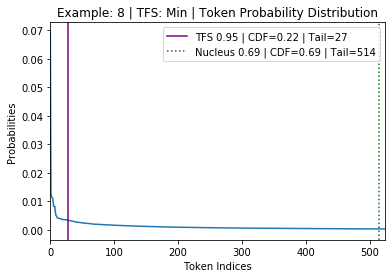

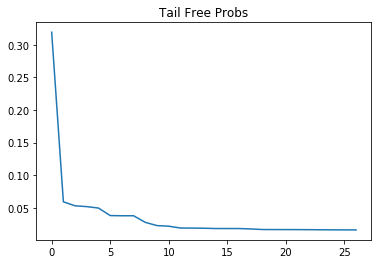

example number 8
cdf looking for: 0.2202293872833252
Time Point: 42
tfs tail id is:  8
tail id is: 8
nucleus tail at: 0.69 746
timepoint 42
cdf is 0.22022939
10 words before are:  him, and his pants were put on backwards.


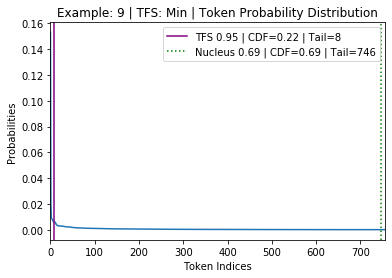

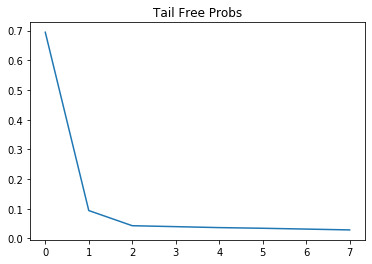

example number 9
cdf looking for: 0.22283299267292023
Time Point: 26
tfs tail id is:  22
tail id is: 22
nucleus tail at: 0.69 1120
timepoint 26
cdf is 0.222833
10 words before are:  strive for more in life. In the meantime,


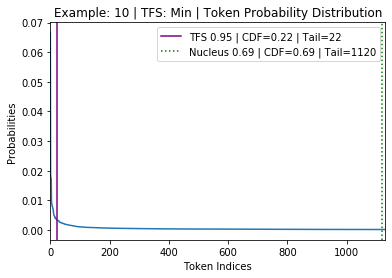

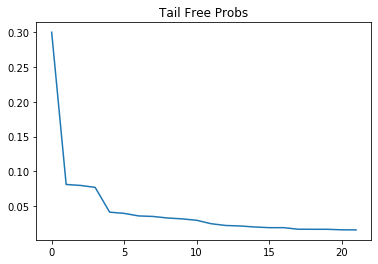

Min or Max?? Max
example number 0
cdf looking for: 0.9058449268341064
Time Point: 110
tfs tail id is:  15
tail id is: 15
nucleus tail at: 0.69 5
timepoint 110
cdf is 0.9058449
10 words before are:  looked in his office, but there it was,


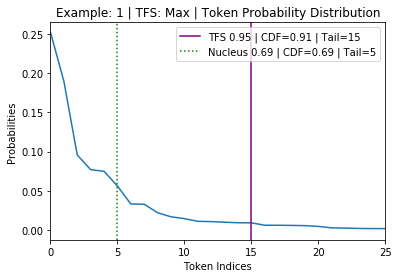

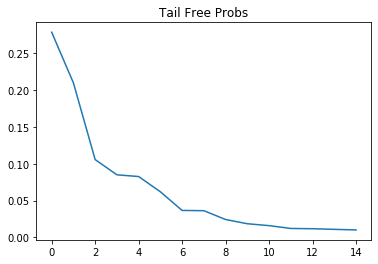

example number 1
cdf looking for: 0.8998998999595642
Time Point: 64
tfs tail id is:  33
tail id is: 33
nucleus tail at: 0.69 15
timepoint 64
cdf is 0.8998999
10 words before are:  The empty feeling in my stomach expands. The clock


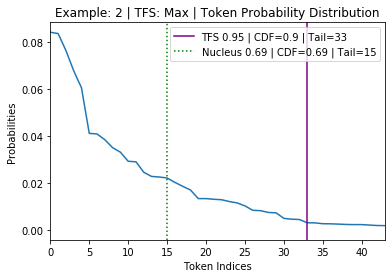

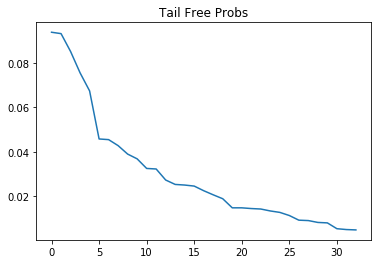

example number 2
cdf looking for: 0.8569539785385132
Time Point: 141
tfs tail id is:  6
tail id is: 6
nucleus tail at: 0.69 3
timepoint 141
cdf is 0.856954
10 words before are:  few hours ago. They came all the way from


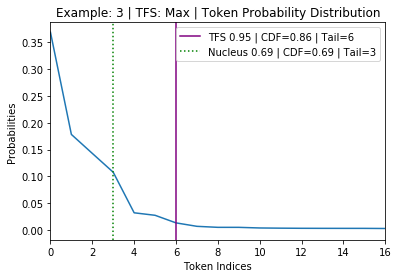

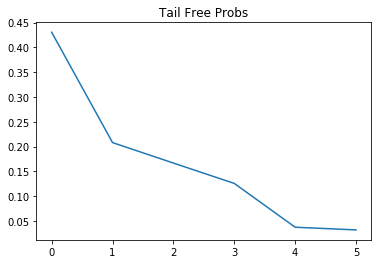

example number 3
cdf looking for: 0.8348177671432495
Time Point: 26
tfs tail id is:  18
tail id is: 18
nucleus tail at: 0.69 7
timepoint 26
cdf is 0.83481777
10 words before are: ed it. Leave it to you to screw things


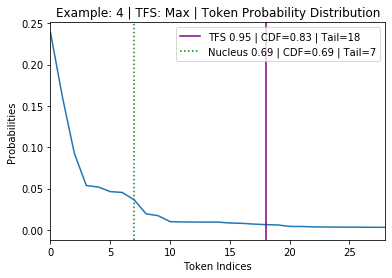

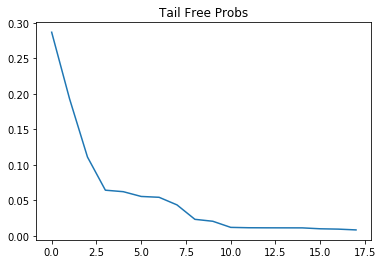

example number 4
cdf looking for: 0.8340668082237244
Time Point: 45
tfs tail id is:  5
tail id is: 5
nucleus tail at: 0.69 2
timepoint 45
cdf is 0.8340668
10 words before are:  training exercise, in every mission, in every place


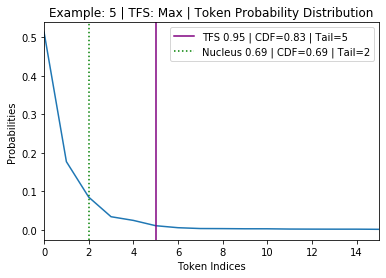

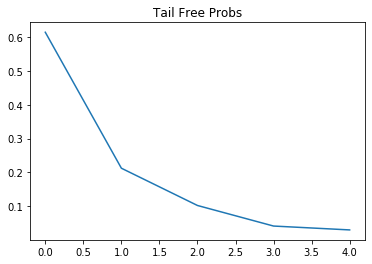

example number 5
cdf looking for: 0.8289777636528015
Time Point: 91
tfs tail id is:  11
tail id is: 11
nucleus tail at: 0.69 5
timepoint 91
cdf is 0.82897776
10 words before are:  they struggle here just as they would anywhere -- nobody


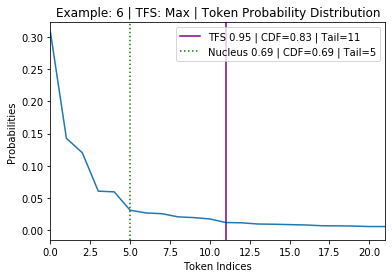

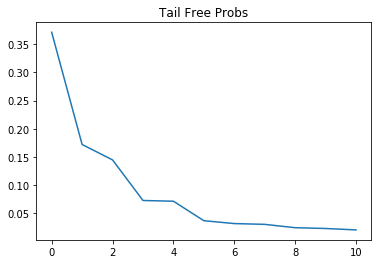

example number 6
cdf looking for: 0.8225667476654053
Time Point: 111
tfs tail id is:  3
tail id is: 3
nucleus tail at: 0.69 1
timepoint 111
cdf is 0.82256675
10 words before are:  probably could have been avoided if they would have just


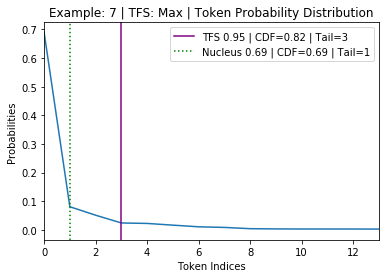

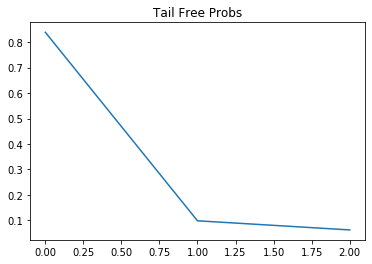

example number 7
cdf looking for: 0.8144689202308655
Time Point: 27
tfs tail id is:  17
tail id is: 17
nucleus tail at: 0.69 7
timepoint 27
cdf is 0.8144689
10 words before are:  for more in life. In the meantime, the


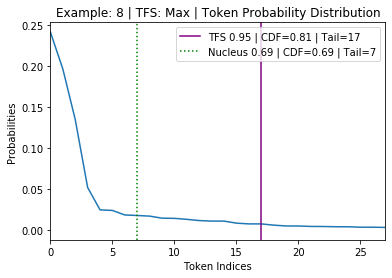

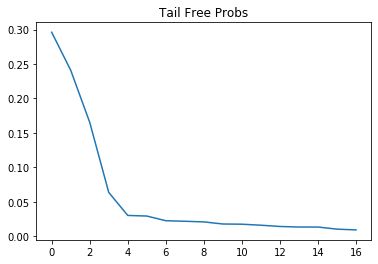

example number 8
cdf looking for: 0.8068912029266357
Time Point: 58
tfs tail id is:  26
tail id is: 26
nucleus tail at: 0.69 13
timepoint 58
cdf is 0.8068912
10 words before are:  duty, but guess who got to sit at the


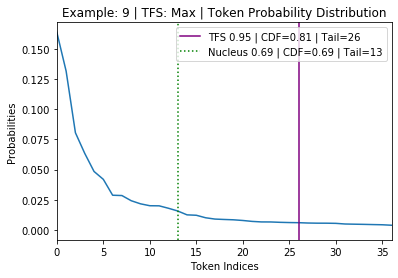

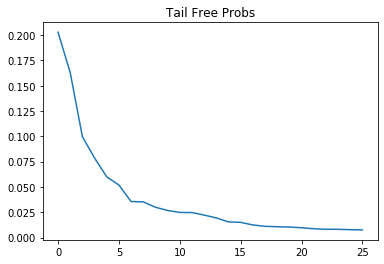

example number 9
cdf looking for: 0.8063088655471802
Time Point: 104
tfs tail id is:  11
tail id is: 11
nucleus tail at: 0.69 6
timepoint 104
cdf is 0.80630887
10 words before are:  nuclear disaster in 2045 and were forced to live


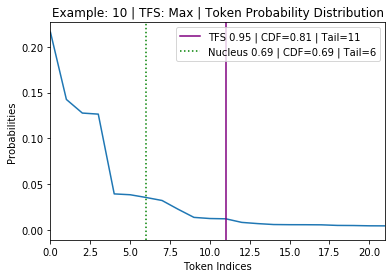

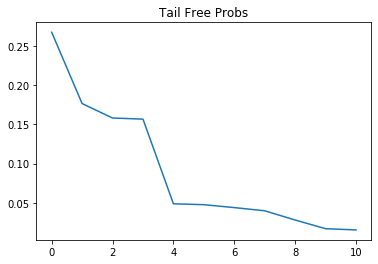

In [73]:
# loop through all of these values. 
from decodeLogits import *

import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    

from importlib import reload
import utils
reload(utils)
from utils import *

gen_length =150
num_batches = 4

key =tfs_type.split('-')[0]
par = tfs_type.split('_')[-1]
par = float(par)

for min_or_max, to_print in zip([min_example_inds, max_example_inds], ['Min', 'Max']):
    print('Min or Max??', to_print)
    for example_ind, example in enumerate(min_or_max):
        print('example number', example_ind)
        arg_val = example
        print('cdf looking for:', tail_cdf_df[tfs_type].iloc[arg_val])
        select_the_prompt = arg_val // gen_length
        time_point = arg_val - ((arg_val // gen_length) *gen_length)

        time_start = time_point
        time_end = time_point +1
        #print(time_start, time_end)
        #all_tail_cdfs[key+'-sampling-type_'+str(par)][select_a_random_prompt,time_start:time_end]

        inds_passed = 0
        for b in range(num_batches):
            batch_size = len(text[b])
            inds_passed += batch_size
            if inds_passed > select_the_prompt:
                batch=b
                ind = select_the_prompt - (inds_passed-batch_size)
                break
        
        
        for time_point in range(time_start, time_end):
            print('Time Point:', time_point)

            sps = softmax(-np.sort(-all_logits[batch][ind, time_point,: ]))
            indices = np.argsort(-all_logits[batch][ind, time_point, : ])
            first = sps[1:] - sps[:-1]
            second = first[1:] - first[:-1]

            plt.plot(np.arange(sps.shape[0]),sps)

            print('tfs tail id is: ', new_tfs(second, par))
            
            if key == 'tfs':
                tail_id = new_tfs(second, par)
            elif key=='flat':
                tail_id = flat(sps, par)

            print('tail id is:', tail_id)
            lab = 'TFS '+str(par)+' | CDF='+str(round(np.sum(sps[:tail_id]),2))+' | Tail='+str(tail_id)
            plt.axvline(tail_id, color='purple', linestyle='solid', label=lab)

            nuc_tails = [] # 0.1, 0.25, 0.5, 0.75 0.9
            for t in [0.69]:#[0.63, 0.69, 0.81]:
                nuc_tail =  nucleus_calc(sps, t)
                print('nucleus tail at:', t, nuc_tail)
                lab = 'Nucleus '+str(t)+' | CDF='+str(round(np.sum(sps[:nuc_tail]),2))+' | Tail='+str(nuc_tail)
                plt.axvline(nuc_tail, color='green', linestyle='dotted', label=lab)

            print('timepoint', time_point)
            print('cdf is', np.sum(sps[:tail_id]))

            print('10 words before are:', decoder_text( text[batch][ind][(prompt_length+time_point-10):(prompt_length+time_point)]) )

            plot_window_lim = max(tail_id, nuc_tail)+10
            
            plt.xlim([0,plot_window_lim])
            #plt.xticks(np.arange(plot_window_lim), decoder_text(indices[:plot_window_lim]).split(' ')[1:], rotation='vertical')
            plt.title('Example: '+str(example_ind+1)+' | TFS: '+to_print + ' | Token Probability Distribution')
            plt.legend(loc='upper right')
            plt.xlabel('Token Indices')
            plt.ylabel('Probabilities')
            plt.gcf().savefig('ImageOutputs/MaxDisagreement_TFS_zeroNine_'+to_print+'_example-'+str(example_ind)+'.png', dpi=250)
            plt.show()

            '''plt.plot(np.arange(second.shape[0]),second)
            plt.xlim([0,plot_window_lim])abs
            plt.axhline(0.00001, color='red', linestyle='solid')
            plt.title('Second Gradient')
            plt.show()'''

            ids_above_tail = indices[:tail_id] # use these indices to determine what the words are and their probabilities. 
            tail_free_probs = softmax(all_logits[batch][ind, time_point, ids_above_tail ])

            plt.plot(np.arange(tail_free_probs.shape[0]), tail_free_probs)
            plt.title('Tail Free Probs')
            #plt.xticks(np.arange(tail_free_probs.shape[0]), decoder_text(ids_above_tail).split(' ')[1:], rotation='vertical')
            plt.show()

            print('=============')




## Randomly selecting logits and drawing TFS points on them

In [74]:
tail_id_df.keys()

Index(['tfs-sampling-type_0.25', 'tfs-sampling-type_0.75',
       'tfs-sampling-type_0.9', 'tfs-sampling-type_0.95',
       'tfs-sampling-type_0.99', 'flat-sampling-type_0.01',
       'flat-sampling-type_0.02', 'flat-sampling-type_0.05',
       'n-sampling-type_0.1', 'n-sampling-type_0.25', 'n-sampling-type_0.5',
       'n-sampling-type_0.63', 'n-sampling-type_0.69', 'n-sampling-type_0.75',
       'n-sampling-type_0.81', 'n-sampling-type_0.9', 'k-sampling-type_1',
       'k-sampling-type_10', 'k-sampling-type_40', 'k-sampling-type_200'],
      dtype='object')

In [83]:
np.random.seed(22)
# [4159, 8149, 1735, 7382, 4385, 5800, 9940,  760,  184, 7823]

In [96]:
rand_inds = np.random.choice(range(tail_id_df['tfs-sampling-type_0.25'].shape[0]), 10)
rand_inds

array([4159, 8149, 1735, 7382, 4385, 5800, 9940,  760,  184, 7823])

In [97]:
np.random.choice(range(150),1)

array([21])

example number 0
cdf looking for: 0.8934683203697205
Time Point: 141
tail thresh value 0.25
tfs tail at: 0.25 1
tail thresh value 0.75
tfs tail at: 0.75 7
tail thresh value 0.9
tfs tail at: 0.9 14
tail thresh value 0.95
tfs tail at: 0.95 36
tail thresh value 0.99
tfs tail at: 0.99 132
timepoint 141
cdf is 0.8169739
10 words before are:  you thinking?! RUN! ''Brian yells, trying


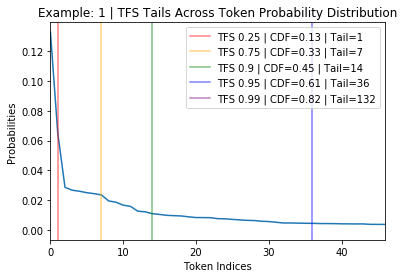

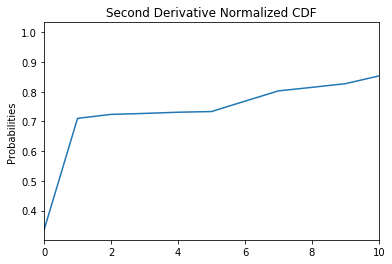

example number 1
cdf looking for: 0.8171307444572449
Time Point: 121
tail thresh value 0.25
tfs tail at: 0.25 1
tail thresh value 0.75
tfs tail at: 0.75 2
tail thresh value 0.9
tfs tail at: 0.9 2
tail thresh value 0.95
tfs tail at: 0.95 2
tail thresh value 0.99
tfs tail at: 0.99 10
timepoint 121
cdf is 0.8154556
10 words before are:  music, art and drama clubs, he is captain


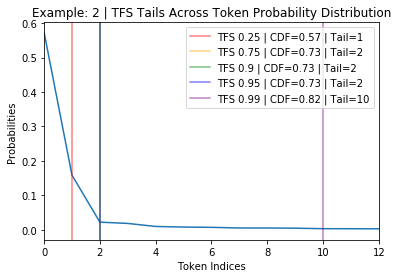

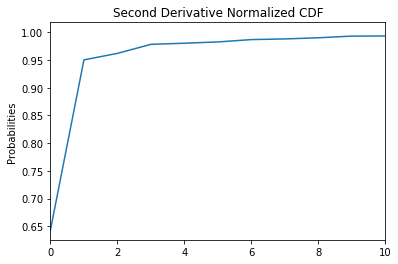

example number 2
cdf looking for: 0.8627776503562927
Time Point: 54
tail thresh value 0.25
tfs tail at: 0.25 2
tail thresh value 0.75
tfs tail at: 0.75 4
tail thresh value 0.9
tfs tail at: 0.9 24
tail thresh value 0.95
tfs tail at: 0.95 46
tail thresh value 0.99
tfs tail at: 0.99 207
timepoint 54
cdf is 0.6859341
10 words before are:  sighed deeply and wiped my brow. What shitter


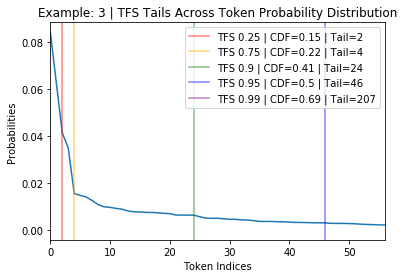

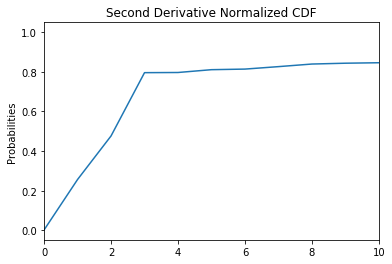

example number 3
cdf looking for: 0.782879114151001
Time Point: 127
tail thresh value 0.25
tfs tail at: 0.25 3
tail thresh value 0.75
tfs tail at: 0.75 3
tail thresh value 0.9
tfs tail at: 0.9 8
tail thresh value 0.95
tfs tail at: 0.95 8
tail thresh value 0.99
tfs tail at: 0.99 14
timepoint 127
cdf is 0.93253297
10 words before are: ed to the elevator. When I got to the


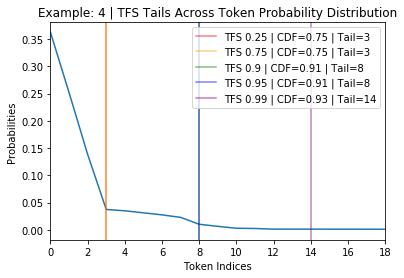

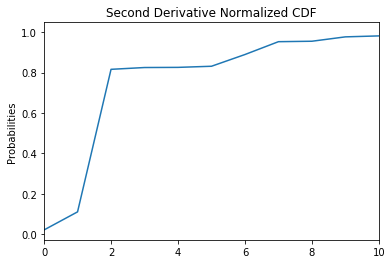

example number 4
cdf looking for: 0.8044085502624512
Time Point: 87
tail thresh value 0.25
tfs tail at: 0.25 1
tail thresh value 0.75
tfs tail at: 0.75 5
tail thresh value 0.9
tfs tail at: 0.9 7
tail thresh value 0.95
tfs tail at: 0.95 11
tail thresh value 0.99
tfs tail at: 0.99 45
timepoint 87
cdf is 0.8179395
10 words before are:  soul purchased the Evil Overlord Handbook. Maybe a


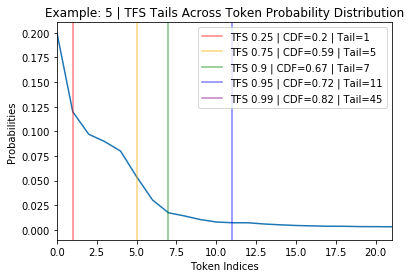

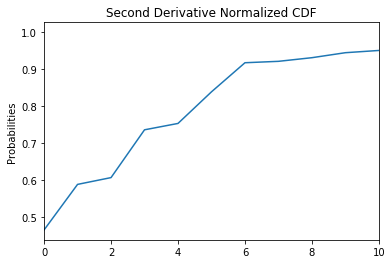

example number 5
cdf looking for: 0.7227577567100525
Time Point: 139
tail thresh value 0.25
tfs tail at: 0.25 2
tail thresh value 0.75
tfs tail at: 0.75 4
tail thresh value 0.9
tfs tail at: 0.9 4
tail thresh value 0.95
tfs tail at: 0.95 7
tail thresh value 0.99
tfs tail at: 0.99 17
timepoint 139
cdf is 0.8044489
10 words before are:  upon completion of your paperwork you will be transferred immediately


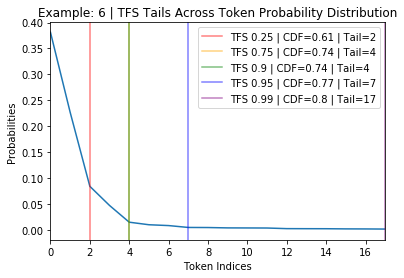

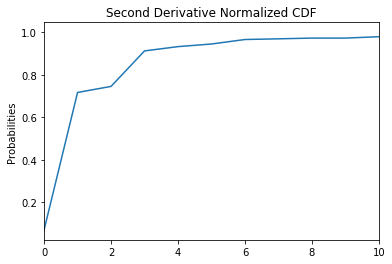

example number 6
cdf looking for: 0.9044778943061829
Time Point: 3
tail thresh value 0.25
tfs tail at: 0.25 2
tail thresh value 0.75
tfs tail at: 0.75 6
tail thresh value 0.9
tfs tail at: 0.9 9
tail thresh value 0.95
tfs tail at: 0.95 14
tail thresh value 0.99
tfs tail at: 0.99 47
timepoint 3
cdf is 0.8501385
10 words before are:  time we will all yell out a number 1-


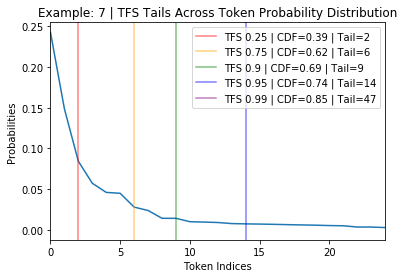

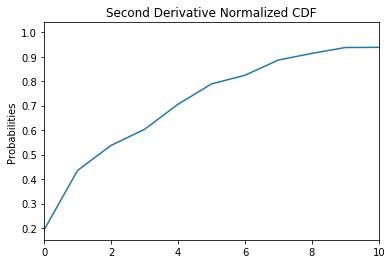

example number 7
cdf looking for: 0.8464774489402771
Time Point: 45
tail thresh value 0.25
tfs tail at: 0.25 1
tail thresh value 0.75
tfs tail at: 0.75 9
tail thresh value 0.9
tfs tail at: 0.9 25
tail thresh value 0.95
tfs tail at: 0.95 58
tail thresh value 0.99
tfs tail at: 0.99 212
timepoint 45
cdf is 0.7124541
10 words before are: . NON ran on love and hope, on charity


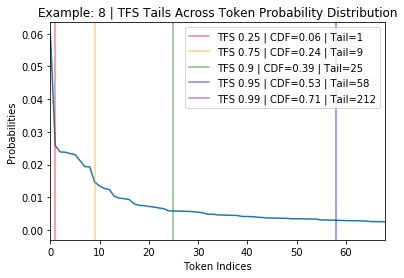

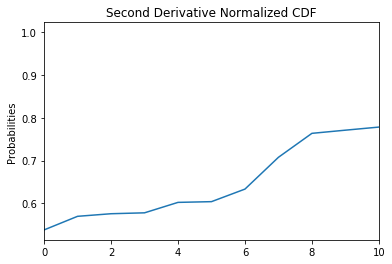

example number 8
cdf looking for: 0.6736283898353577
Time Point: 60
tail thresh value 0.25
tfs tail at: 0.25 1
tail thresh value 0.75
tfs tail at: 0.75 5
tail thresh value 0.9
tfs tail at: 0.9 12
tail thresh value 0.95
tfs tail at: 0.95 21
tail thresh value 0.99
tfs tail at: 0.99 145
timepoint 60
cdf is 0.6583488
10 words before are:  twisted out of my ruse and stared at the


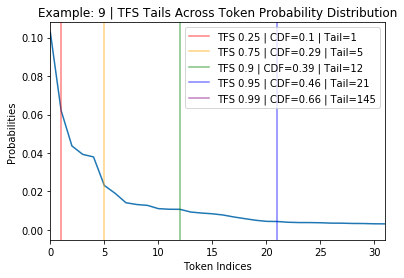

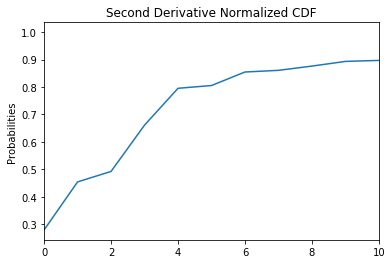

example number 9
cdf looking for: 0.8952631950378418
Time Point: 18
tail thresh value 0.25
tfs tail at: 0.25 2
tail thresh value 0.75
tfs tail at: 0.75 6
tail thresh value 0.9
tfs tail at: 0.9 7
tail thresh value 0.95
tfs tail at: 0.95 12
tail thresh value 0.99
tfs tail at: 0.99 43
timepoint 18
cdf is 0.8914677
10 words before are:  
 I awkwardly gripped the handle of my bat


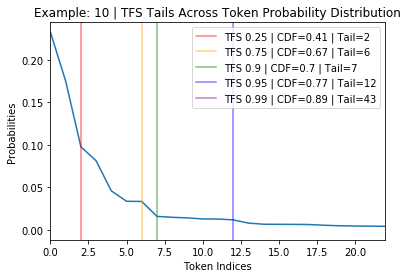

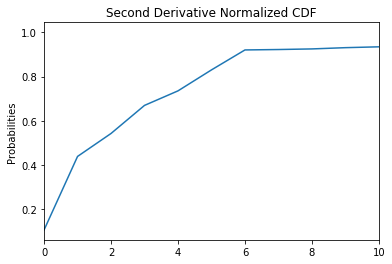

In [105]:
# loop through all of these values. 
from decodeLogits import *

import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    

from importlib import reload
import utils
reload(utils)
from utils import *

tfs_vals = [0.25, 0.75, 0.9, 0.95, 0.99]
colors = ['red', 'orange', 'green', 'blue', 'purple' ]
gen_length =150
num_batches = 4

'''key =tfs_type.split('-')[0]
par = tfs_type.split('_')[-1]
par = float(par)'''

for example_ind, example in enumerate(rand_inds):
    print('example number', example_ind)
    arg_val = example
    print('cdf looking for:', tail_cdf_df[tfs_type].iloc[arg_val])
    select_the_prompt = arg_val // gen_length
    time_point = np.random.choice(range(150),1)[0]
    
    #arg_val - ((arg_val // gen_length) *gen_length)

    time_start = time_point
    time_end = time_point +1
    #print(time_start, time_end)
    #all_tail_cdfs[key+'-sampling-type_'+str(par)][select_a_random_prompt,time_start:time_end]

    inds_passed = 0
    for b in range(num_batches):
        batch_size = len(text[b])
        inds_passed += batch_size
        if inds_passed > select_the_prompt:
            batch=b
            ind = select_the_prompt - (inds_passed-batch_size)
            break

    for time_point in range(time_start, time_end):
        print('Time Point:', time_point)

        sps = softmax(-np.sort(-all_logits[batch][ind, time_point,: ]))
        indices = np.argsort(-all_logits[batch][ind, time_point, : ])
        first = sps[1:] - sps[:-1]
        second = first[1:] - first[:-1]

        plt.plot(np.arange(sps.shape[0]),sps)

        #print('tfs tail id is: ', new_tfs(second, par))

        '''if key == 'tfs':
            tail_id = new_tfs(second, par)
        elif key=='flat':
            tail_id = flat(sps, par)
            '''
            
        for tfs_ind, t in enumerate(tfs_vals):#[0.63, 0.69, 0.81]:
            
            print('tail thresh value', t)
            tfs_tail =  new_tfs(second, t)
            if t ==0.95:
                wind_lim_ref = tfs_tail
            print('tfs tail at:', t, tfs_tail)
            lab = 'TFS '+str(t)+' | CDF='+str(round(np.sum(sps[:tfs_tail]),2))+' | Tail='+str(tfs_tail)
            plt.axvline(tfs_tail, alpha=0.5, color=colors[tfs_ind], label=lab) # color='purple', linestyle='dotted',

        print('timepoint', time_point)
        print('cdf is', np.sum(sps[:tfs_tail]))

        print('10 words before are:', decoder_text( text[batch][ind][(prompt_length+time_point-10):(prompt_length+time_point)]) )

        plot_window_lim = wind_lim_ref+10

        plt.xlim([0,plot_window_lim])
        #plt.xticks(np.arange(plot_window_lim), decoder_text(indices[:plot_window_lim]).split(' ')[1:], rotation='vertical')
        plt.title('Example: '+str(example_ind+1)+' | TFS Tails Across Token Probability Distribution')
        plt.legend(loc='upper right')
        plt.xlabel('Token Indices')
        plt.ylabel('Probabilities')
        plt.gcf().savefig('ImageOutputs/Different_TFS_Values_example-'+str(example_ind)+'.png', dpi=250)
        plt.show()
        
        only_pos = np.abs(second)
        sec_indices = np.arange(len(second))
        sec_weights = only_pos/only_pos.sum()
        
        plt.plot(np.arange(0,len(sec_weights)), np.cumsum(sec_weights))
        #plt.axhline(0.00001, color='purple', linestyle='solid')
        plt.xlim([0,10])
        plt.title('Second Derivative Normalized CDF')
        plt.ylabel('Probabilities')
        plt.show()

        '''plt.plot(np.arange(second.shape[0]),second)
        plt.xlim([0,plot_window_lim])abs
        plt.axhline(0.00001, color='red', linestyle='solid')
        plt.title('Second Gradient')
        plt.show()'''

        '''ids_above_tail = indices[:tfs_tail] # use these indices to determine what the words are and their probabilities. 
        tail_free_probs = softmax(all_logits[batch][ind, time_point, ids_above_tail ])

        plt.plot(np.arange(tail_free_probs.shape[0]), tail_free_probs)
        plt.title('Tail Free Probs')
        #plt.xticks(np.arange(tail_free_probs.shape[0]), decoder_text(ids_above_tail).split(' ')[1:], rotation='vertical')
        plt.show()'''

        print('=============')




## Looking at a specific example of the min

In [444]:
argmin = tail_cdf_df[tfs_type].idxmin()

In [445]:
argmin # = 

10833

In [448]:
tail_cdf_df[tfs_type].iloc[argmin]

0.32533031702041626

In [449]:
tail_cdf_df[nuc_type].iloc[argmin]

0.7500282526016235

In [450]:
gen_length

150

In [451]:
gen_length =150
print('prompt number:', (argmin // gen_length))
print('time point', argmin - ((argmin // gen_length) *gen_length))


prompt number: 72
time point 33


In [452]:
all_tail_cdfs[key+'-sampling-type_'+str(par)].shape

(92, 150)

In [455]:
key =tfs_type.split('-')[0]
par = tfs_type.split('_')[-1]
select_a_random_prompt = argmin // gen_length
time_point = argmin - ((argmin // gen_length) *gen_length)

time_start = time_point-3
time_end = time_point +3
print(time_start, time_end)
all_tail_cdfs[key+'-sampling-type_'+str(par)][select_a_random_prompt,time_start:time_end]

30 36


array([0.76738828, 0.90697891, 0.55980957, 0.32533032, 0.71029431,
       0.78873372])

In [454]:
select_a_random_prompt

72

In [456]:
ind_wanted = select_a_random_prompt
ind_wanted

72

In [457]:
'''del all_logits
gpt_out_path = 'gpt-2_output/'
#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))'''

"del all_logits\ngpt_out_path = 'gpt-2_output/'\n#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))\nall_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities\ntext = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))"

In [458]:

from decodeLogits import *

inds_passed = 0
for b in range(num_batches):
    batch_size = len(text[b])
    inds_passed += batch_size
    if inds_passed > ind_wanted:
        batch=b
        ind = ind_wanted - (inds_passed-batch_size)
        break
    

In [459]:
(batch, ind)

(3, 2)

In [460]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [461]:
all_logits[0].shape

(23, 150, 50257)

Prompt: 

[WP] Global suicide rates rises rapidly. The governments deny responsibility. You know better. 
 “There is no evidence to support the accusation that Ambilifix (TM) is contributing to the rash of recent suicides. The FDA is opening a full investigation and I assure you, that we ’ ll get to the bottom of this soon. ” The tailored-suit spokeswoman looked comfortable in the glare of the lights and invasion of the microphones. It was almost as if she already knew

 
Generation: 
 
 the FDA would find nothing. 
 It was my job as coordinator to make sure that was the case. 
 There was a long and complicated paper trail of the drug throughout its life cycle. That, of course, was unavoidable. But the antidepressant ’ s real purpose was never publicly disclosed. Only four people are aware of the extent of the dark net research cluster that created the drug. The underground links between six of the world ’ s leading pharmaceutical companies had to stay hidden. Shareholders would never 

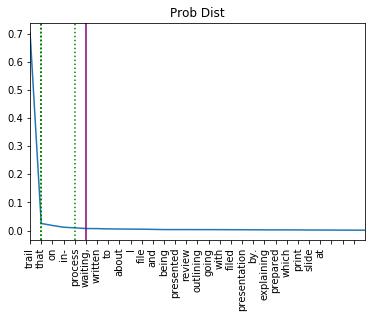

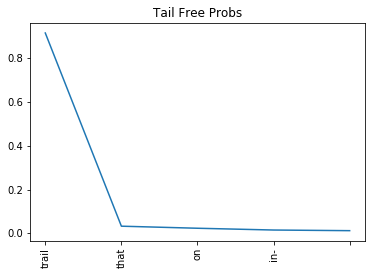

Time Point: 31
tail id is: 106
nucleus tail at: 0.1 1
nucleus tail at: 0.25 2
nucleus tail at: 0.5 6
nucleus tail at: 0.75 20
nucleus tail at: 0.9 96
timepoint 31
cdf is 0.9069789
10 words before are: . 
 There was a long and complicated paper


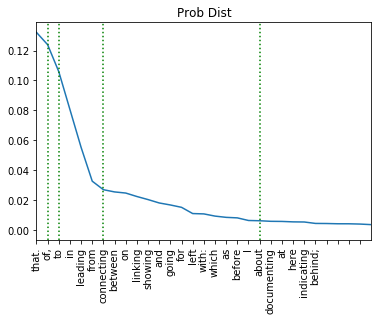

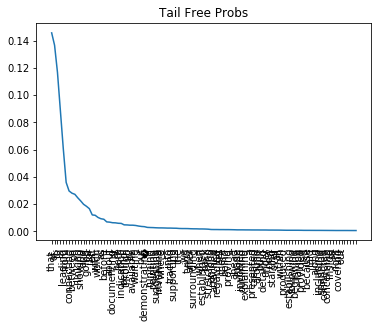

Time Point: 32
tail id is: 174
nucleus tail at: 0.1 2
nucleus tail at: 0.25 15
nucleus tail at: 0.5 115
nucleus tail at: 0.75 697
nucleus tail at: 0.9 2878
timepoint 32
cdf is 0.55980957
10 words before are:  
 There was a long and complicated paper trail


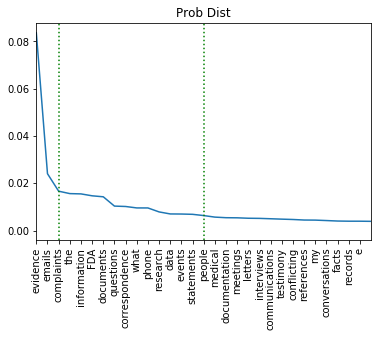

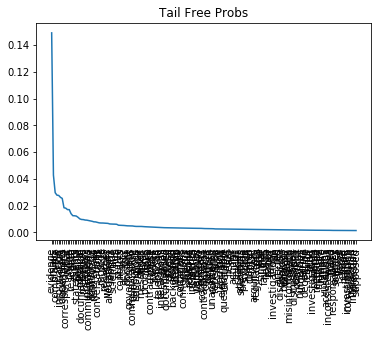

Time Point: 33
tail id is: 28
nucleus tail at: 0.1 1
nucleus tail at: 0.25 7
nucleus tail at: 0.5 192
nucleus tail at: 0.75 1245
nucleus tail at: 0.9 4336
timepoint 33
cdf is 0.32533032
10 words before are: 
 There was a long and complicated paper trail of


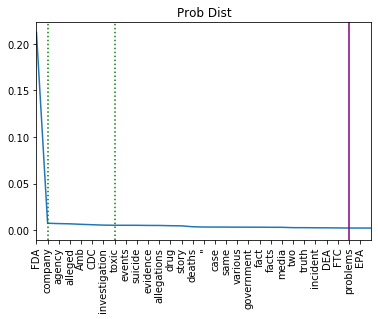

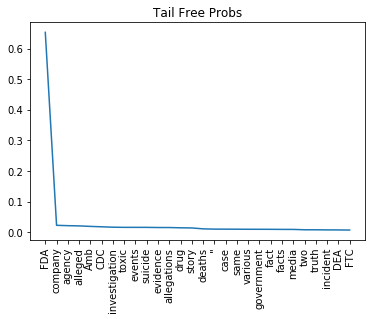

Time Point: 34
tail id is: 36
nucleus tail at: 0.1 1
nucleus tail at: 0.25 2
nucleus tail at: 0.5 6
nucleus tail at: 0.75 68
nucleus tail at: 0.9 738
timepoint 34
cdf is 0.7102943
10 words before are:  There was a long and complicated paper trail of the


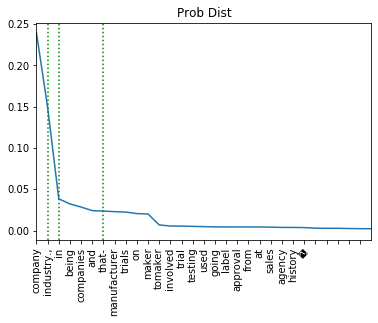

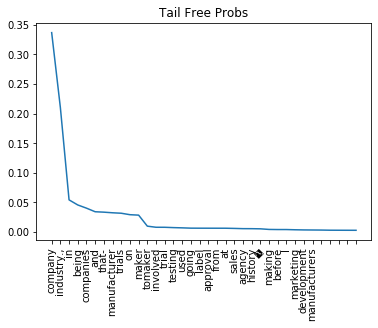

Time Point: 35
tail id is: 20
nucleus tail at: 0.1 1
nucleus tail at: 0.25 1
nucleus tail at: 0.5 2
nucleus tail at: 0.75 11
nucleus tail at: 0.9 209
timepoint 35
cdf is 0.7887337
10 words before are:  was a long and complicated paper trail of the drug


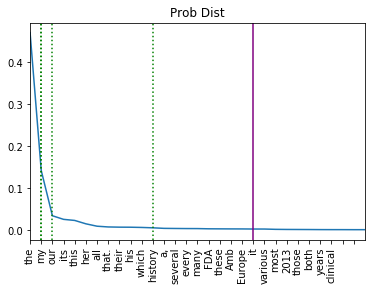

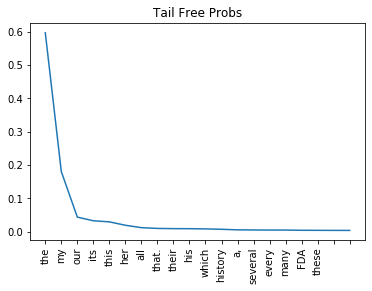

In [462]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

#time_point = 1
plot_window_lim =30
par = float(par)
print('Prompt: \n')
print(decoder_text( text[batch][ind][:prompt_length]))
print('\n ====== \n ')
print('Generation: \n ')
gen = text[batch][ind][prompt_length:]
print(decoder_text( text[batch][ind][prompt_length:]))
print('======')

for time_point in range(time_start, time_end):
    print('Time Point:', time_point)
    
    sps = softmax(-np.sort(-all_logits[batch][ind, time_point,: ]))
    
    indices = np.argsort(-all_logits[batch][ind, time_point, : ])
    first = sps[1:] - sps[:-1]
    second = first[1:] - first[:-1]
    
    plt.plot(np.arange(sps.shape[0]),sps)
    
    if key == 'tfs':
        #sps = np.around(sps,3)
        tail_id = new_tfs(second, par)
    elif key=='flat':
        tail_id = flat(sps, par)
    
    print('tail id is:', tail_id)
    plt.axvline(tail_id, color='purple', linestyle='solid')
    
    nuc_tails = []
    for t in [0.1, 0.25, 0.5, 0.75, 0.9]:
        nuc_tail =  nucleus_calc(sps, t)
        print('nucleus tail at:', t, nuc_tail)
        plt.axvline(nuc_tail, color='green', linestyle='dotted')
    
    print('timepoint', time_point)
    print('cdf is', np.sum(sps[:tail_id]))
    
    print('10 words before are:', decoder_text( text[batch][ind][(prompt_length+time_point-10):(prompt_length+time_point)]) )
    
    plt.xlim([0,plot_window_lim])
    plt.xticks(np.arange(plot_window_lim), decoder_text(indices[:plot_window_lim]).split(' ')[1:], rotation='vertical')
    plt.title('Prob Dist')
    plt.show()
        
    '''plt.plot(np.arange(second.shape[0]),second)
    plt.xlim([0,plot_window_lim])abs
    plt.axhline(0.00001, color='red', linestyle='solid')
    plt.title('Second Gradient')
    plt.show()'''
        
    ids_above_tail = indices[:tail_id] # use these indices to determine what the words are and their probabilities. 
    tail_free_probs = softmax(all_logits[batch][ind, time_point, ids_above_tail ])

    plt.plot(np.arange(tail_free_probs.shape[0]), tail_free_probs)
    plt.title('Tail Free Probs')
    plt.xticks(np.arange(tail_free_probs.shape[0]), decoder_text(ids_above_tail).split(' ')[1:], rotation='vertical')
    plt.show()

    #print('words in order',decoder_text(ids_above_tail))

    print('=============')

# Now finding the highest ones

In [463]:

tfs_type = 'tfs-sampling-type_0.99'
nuc_type = 'n-sampling-type_0.75'
mask=np.logical_and(tail_cdf_df[tfs_type]>0.99, 
                    tail_cdf_df[nuc_type]<0.76)
tail_cdf_df[tfs_type][mask]

2410     0.994257
5257     0.996381
6716     0.996125
13298    0.990615
13695    0.995232
Name: tfs-sampling-type_0.99, dtype: float64

In [464]:
tail_cdf_df[tfs_type][mask].shape

(5,)

In [467]:
argmin = tail_cdf_df[tfs_type][mask].idxmax()

In [468]:
argmin #= 5104

5257

In [469]:
tail_cdf_df[tfs_type].iloc[argmin]

0.9963806867599487

In [470]:
tail_cdf_df[nuc_type].iloc[argmin]

0.7537432909011841

In [471]:
gen_length =150
print('prompt number:', (argmin // gen_length))
print('time point', argmin - ((argmin // gen_length) *gen_length))


prompt number: 35
time point 7


In [472]:
select_a_random_prompt

72

In [473]:
key =tfs_type.split('-')[0]
par = tfs_type.split('_')[-1]
select_a_random_prompt = argmin // gen_length
time_point = argmin - ((argmin // gen_length) *gen_length)
print(key, par)
time_start = time_point-3
time_end = time_point +3
print('time interval', time_start, time_end)
all_tail_cdfs[key+'-sampling-type_'+str(par)][select_a_random_prompt,time_start:time_end]

tfs 0.99
time interval 4 10


array([0.78900087, 0.81886965, 0.91403162, 0.99638069, 0.95487785,
       0.8501631 ])

In [474]:
select_a_random_prompt

35

In [475]:
ind_wanted = select_a_random_prompt

In [477]:
'''del all_logits
gpt_out_path = 'gpt-2_output/'
#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))'''

"del all_logits\ngpt_out_path = 'gpt-2_output/'\n#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))\nall_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities\ntext = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))"

In [478]:
len(text[0])

23

In [479]:
from decodeLogits import *

inds_passed = 0
for b in range(num_batches):
    batch_size = len(text[b])
    inds_passed += batch_size
    if inds_passed > ind_wanted:
        batch=b
        ind = ind_wanted - (inds_passed-batch_size)
        break
    

#batch = (ind_wanted//batch_size)
#ind = ind_wanted - (batch*batch_size)

In [480]:
(batch, ind)

(1, 12)

In [481]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [482]:
all_tail_cdfs[key+'-sampling-type_'+str(par)][select_a_random_prompt,time_start:time_end]

array([0.78900087, 0.81886965, 0.91403162, 0.99638069, 0.95487785,
       0.8501631 ])

In [483]:
select_a_random_prompt

35

In [484]:
tot_good_samples[select_a_random_prompt]

35

In [485]:
(batch,ind)

(1, 12)

In [486]:
len(text[1])

23

Prompt: 

[WP] Our character accidentally completed an occultist ritual and summons a powerful archdemon. Being a good person however and with the demon requesting a task, they opt for more mundane requests than their new servant is used to. 
 ``Oh shit I did it again. STEVE GET THE FOOD ''
 At the old mans words a young boy rushes into the room with a bucket of carrots in one hand and potatoes in another, he did n't even bother to look at the flaming figure

 
Generation: 
 
 standing across the room before he scurried off again. 
 
 The old man looked towards the demon, who had chosen to take the form of the sorcerers wife burning in anguish. 
 
`` Knock that off!'' Barked the man, whacking the demon with a newspaper until it chose the much more pleasant form of an eight legged horse. 
 
 ``This is what's going to happen. I ca n't get rid of you until you do my bidding. Take that knife and start chopping some of those veggies, there's a couple dozen homeless folk who would have seen 

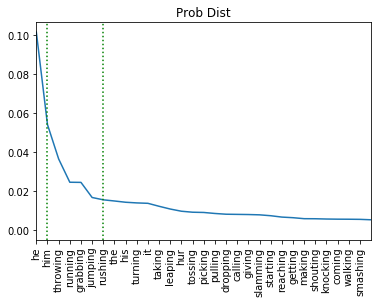

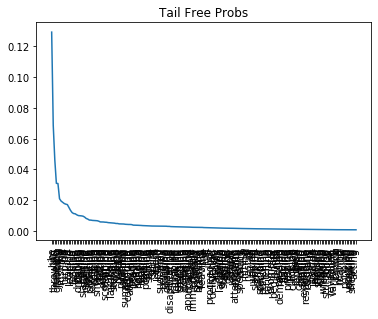

Time Point: 5
tail id is: 396
nucleus tail at: 0.1 3
nucleus tail at: 0.25 12
nucleus tail at: 0.5 64
nucleus tail at: 0.75 253
nucleus tail at: 0.9 772
timepoint 5
cdf is 0.81886965
10 words before are:  look at the flaming figure standing across the room before


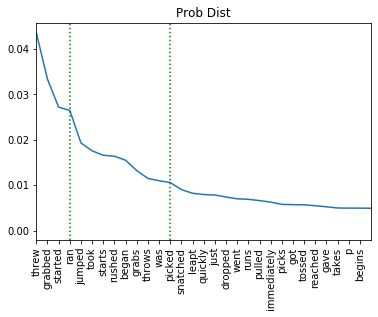

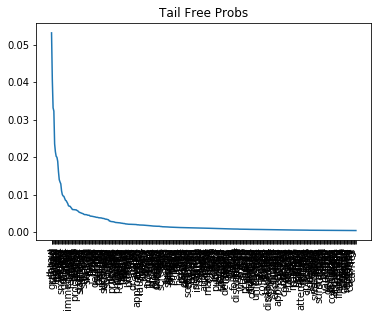

Time Point: 6
tail id is: 11
nucleus tail at: 0.1 1
nucleus tail at: 0.25 1
nucleus tail at: 0.5 1
nucleus tail at: 0.75 1
nucleus tail at: 0.9 10
timepoint 6
cdf is 0.9140316
10 words before are:  at the flaming figure standing across the room before he


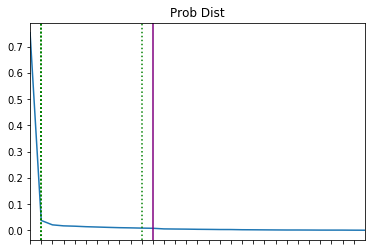

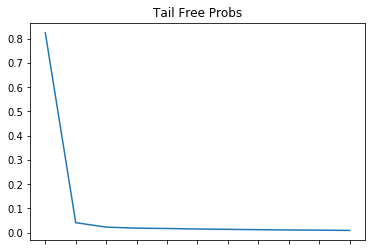

Time Point: 7
tail id is: 2
nucleus tail at: 0.1 1
nucleus tail at: 0.25 1
nucleus tail at: 0.5 1
nucleus tail at: 0.75 1
nucleus tail at: 0.9 2
timepoint 7
cdf is 0.9963807
10 words before are:  the flaming figure standing across the room before he sc


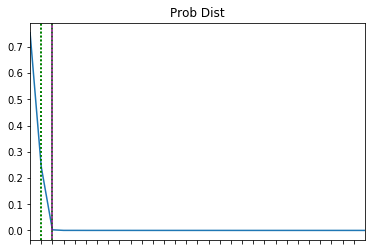

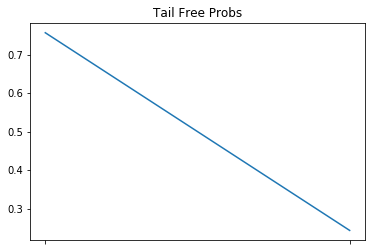

Time Point: 8
tail id is: 31
nucleus tail at: 0.1 1
nucleus tail at: 0.25 2
nucleus tail at: 0.5 3
nucleus tail at: 0.75 7
nucleus tail at: 0.9 15
timepoint 8
cdf is 0.95487785
10 words before are:  flaming figure standing across the room before he scur


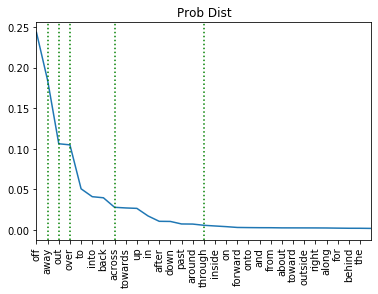

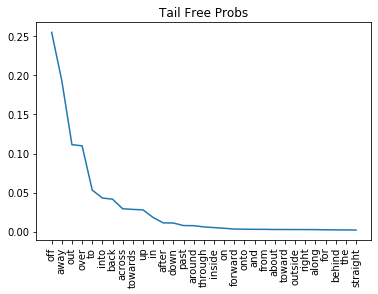

Time Point: 9
tail id is: 32
nucleus tail at: 0.1 1
nucleus tail at: 0.25 2
nucleus tail at: 0.5 5
nucleus tail at: 0.75 13
nucleus tail at: 0.9 67
timepoint 9
cdf is 0.8501631
10 words before are:  figure standing across the room before he scurried


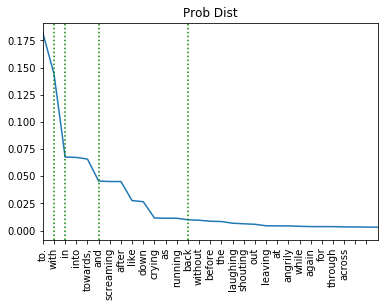

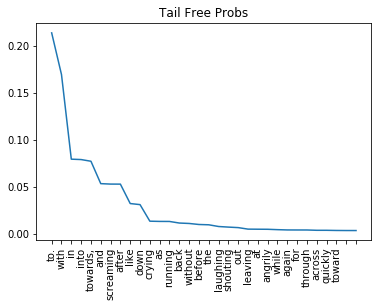

In [488]:
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

par = float(par)
plot_window_lim =30

print('Prompt: \n')
print(decoder_text( text[batch][ind][:prompt_length]))
print('\n ====== \n ')
print('Generation: \n ')
gen = text[batch][ind][prompt_length:]
print(decoder_text( text[batch][ind][prompt_length:]))
print('======')

for time_point in range(time_start, time_end):
    print('Time Point:', time_point)
    
    sps = softmax(-np.sort(-all_logits[batch][ind, time_point,: ]))
    
    indices = np.argsort(-all_logits[batch][ind, time_point, : ])
    first = sps[1:] - sps[:-1]
    second = first[1:] - first[:-1]
    
    plt.plot(np.arange(sps.shape[0]),sps)
    
    if key == 'tfs':
        tail_id = new_tfs(second, par)
    elif key=='flat':
        tail_id = flat(sps, par)
    
    print('tail id is:', tail_id)
    plt.axvline(tail_id, color='purple', linestyle='solid')
    
    nuc_tails = []
    for t in [0.1, 0.25, 0.5, 0.75, 0.9]:
        nuc_tail =  nucleus_calc(sps, t)
        print('nucleus tail at:', t, nuc_tail)
        plt.axvline(nuc_tail, color='green', linestyle='dotted')
    
    print('timepoint', time_point)
    print('cdf is', np.sum(sps[:tail_id]))
    
    print('10 words before are:', decoder_text( text[batch][ind][(prompt_length+time_point-10):(prompt_length+time_point)]) )
    
    plt.xlim([0,plot_window_lim])
    plt.xticks(np.arange(plot_window_lim), decoder_text(indices[:plot_window_lim]).split(' ')[1:], rotation='vertical')
    plt.title('Prob Dist')
    plt.show()
        
    '''plt.plot(np.arange(second.shape[0]),second)
    plt.xlim([0,plot_window_lim])abs
    plt.axhline(0.00001, color='red', linestyle='solid')
    plt.title('Second Gradient')
    plt.show()'''
    
    '''if tail_id>500:
        print('tail ID isnt specific enough, skipping this plot')
        print('=============')
        continue'''
        
    ids_above_tail = indices[:tail_id] # use these indices to determine what the words are and their probabilities. 
    tail_free_probs = softmax(all_logits[batch][ind, time_point, ids_above_tail ])

    plt.plot(np.arange(tail_free_probs.shape[0]), tail_free_probs)
    plt.title('Tail Free Probs')
    plt.xticks(np.arange(tail_free_probs.shape[0]), decoder_text(ids_above_tail).split(' ')[1:], rotation='vertical')
    plt.show()

    #print('words in order',decoder_text(ids_above_tail))

    print('=============')

# Same code as above but applying it to more intervals of the different analyses

In [6]:
inter = list(np.arange(0.05,1,0.05))
inter.insert(0, 0.01)
inter = [round(i,3) for i in inter]
inter

[0.01,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [7]:
k_inter = list(np.arange(4,51,1)) #list(np.arange(1,51,1))
vals_dict = { 'k':k_inter, 'tfs':inter, 'flat':inter,'n': inter,  }

In [8]:
vals_dict

{'k': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'tfs': [0.01,
  0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95],
 'flat': [0.01,
  0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95],
 'n': [0.01,
  0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95]}

In [10]:
tot_num=92

In [11]:
# applying all analyses to the logits. 

#real_log_probs = dict()
ground_token_in_cut = dict()
all_tail_ids = dict()
all_tail_cdfs = dict()
all_ground_word_cdfs = dict()
prompt_length = 100
for key,all_params in vals_dict.items():
    for par in all_params:
        print('key and param', key, '====', par)
        temp_tail_cdfs = np.zeros([tot_num, all_logits[0].shape[1]])
        temp_tail_ids = np.zeros([tot_num, all_logits[0].shape[1]])
        temp_ground_word_cdfs = np.zeros([tot_num, all_logits[0].shape[1]])
        p_ind = 0

        for batch in range(num_batches):
                    #for p_ind in range(batch*batch_size, (batch*batch_size)+batch_size ):
            for ind in range(0,all_logits[batch].shape[0]):
                
                if p_ind%25 == 0:
                    print('index', str(p_ind))

                ground_token_in_cut_temp = []

                for time_point in range(0,all_logits[0].shape[1]):
                    
                    ground_token = text[batch][ind][prompt_length+time_point]
                    
                    sps = softmax(-np.sort(-all_logits[batch][ind, time_point, :]))
                    indices = np.argsort(-all_logits[batch][ind, time_point, :])
            
                    if key == 'tfs':
                        first = sps[1:] - sps[:-1]
                        second = first[1:] - first[:-1]
                        tail_id = new_tfs(second, par)
                    elif key=='flat':
                        tail_id = flat(sps, par)
                    elif key=='n':
                        tail_id = nucleus_calc(sps, par)
                    elif key=='k':
                        tail_id = par
                    else:
                        print('key not recognized')
                        break
                        
                    tail_cdf= np.sum(sps[:tail_id])
                    
                    ground_word_index = np.where(ground_token==indices)[0][0]
                    ground_word_cdf = np.sum(sps[:ground_word_index])
                    
                    temp_tail_ids[p_ind, time_point] = tail_id
                    temp_tail_cdfs[p_ind, time_point] = tail_cdf
                    temp_ground_word_cdfs[p_ind, time_point] = ground_word_cdf
                    
                    ids_above_tail = indices[:tail_id]
                    
                    ground_token_in_cut_temp.append( ground_token in ids_above_tail )
                    
                ground_token_in_cut[key+'-sampling-type_'+str(par)+'prompt_'+str(p_ind)] = ground_token_in_cut_temp
                p_ind+=1
            
        all_tail_ids[key+'-sampling-type_'+str(par)] = temp_tail_ids
        all_tail_cdfs[key+'-sampling-type_'+str(par)] = temp_tail_cdfs
        all_ground_word_cdfs[key+'-sampling-type_'+str(par)] = temp_ground_word_cdfs

key and param k ==== 4
index 0
index 25
index 50
index 75
key and param k ==== 5
index 0
index 25
index 50
index 75
key and param k ==== 6
index 0
index 25
index 50
index 75
key and param k ==== 7
index 0
index 25
index 50
index 75
key and param k ==== 8
index 0
index 25
index 50
index 75
key and param k ==== 9
index 0
index 25
index 50
index 75
key and param k ==== 10
index 0
index 25
index 50
index 75
key and param k ==== 11
index 0
index 25
index 50
index 75
key and param k ==== 12
index 0
index 25
index 50
index 75
key and param k ==== 13
index 0
index 25
index 50
index 75
key and param k ==== 14
index 0
index 25
index 50
index 75
key and param k ==== 15
index 0
index 25
index 50
index 75
key and param k ==== 16
index 0
index 25
index 50
index 75
key and param k ==== 17
index 0
index 25
index 50
index 75
key and param k ==== 18
index 0
index 25
index 50
index 75
key and param k ==== 19
index 0
index 25
index 50
index 75
key and param k ==== 20
index 0
index 25
index 50
index 75
key

In [12]:
''''pickle.dump(all_tail_ids, gzip.open('Precise_Intervals_Tail_IDs_dict_Aug10.pickle', 'wb'))
pickle.dump(all_tail_cdfs, gzip.open('Precise_Intervals_Tail_CDFs_dict_Aug10.pickle', 'wb'))
pickle.dump(ground_token_in_cut, gzip.open('Precise_Intervals_GTruth_In_Cut_Aug10.pickle', 'wb'))
pickle.dump(all_ground_word_cdfs, gzip.open('Precise_Intervals_Ground_Truth_CDFs_Aug10.pickle', 'wb'))''''

In [ ]:
all_tail_ids = pickle.load(gzip.open('Precise_Intervals_Tail_IDs_dict_Aug10.pickle', 'rb'))
all_tail_cdfs = pickle.load(gzip.open('Precise_Intervals_Tail_CDFs_dict_Aug10.pickle', 'rb'))
ground_token_in_cut=pickle.load(gzip.open('Precise_Intervals_GTruth_In_Cut_Aug10.pickle', 'rb'))
all_ground_word_cdfs =pickle.load(gzip.open('Precise_Intervals_Ground_Truth_CDFs_Aug10.pickle', 'rb'))

# Flattening

In [32]:
# need to have them all compete against each other to see what is the highest in each of the positions. 

very_first = True

for key, params in vals_dict.items():
    print('Key is:', key)
    for par in params:
        
        flat_ids = all_tail_ids[key+'-sampling-type_'+str(par)].flatten()
        flat_cdfs = all_tail_cdfs[key+'-sampling-type_'+str(par)].flatten()
        flat_ground_word_cdfs = all_ground_word_cdfs[key+'-sampling-type_'+str(par)].flatten()
        
        if very_first ==True:

            tail_id_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_ids})
            tail_cdf_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_cdfs})
            ground_word_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_ground_word_cdfs})
            
            very_first=False

        else:

            tail_id_df[key+'-sampling-type_'+str(par)] = flat_ids
            tail_cdf_df[key+'-sampling-type_'+str(par)] = flat_cdfs
            ground_word_df[key+'-sampling-type_'+str(par)] = flat_ground_word_cdfs
            
        

Key is: k
Key is: tfs
Key is: flat
Key is: n


In [45]:
tail_id_df.head()

,k-sampling-type_4,k-sampling-type_5,k-sampling-type_6,k-sampling-type_7,k-sampling-type_8,k-sampling-type_9,k-sampling-type_10,k-sampling-type_11,k-sampling-type_12,k-sampling-type_13,...,n-sampling-type_0.5,n-sampling-type_0.55,n-sampling-type_0.6,n-sampling-type_0.65,n-sampling-type_0.7,n-sampling-type_0.75,n-sampling-type_0.8,n-sampling-type_0.85,n-sampling-type_0.9,n-sampling-type_0.95
0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,...,85.0,118.0,164.0,230.0,328.0,478.0,708.0,1098.0,1838.0,3620.0
1,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,...,10.0,13.0,19.0,29.0,50.0,93.0,178.0,358.0,766.0,2143.0
2,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,...,92.0,124.0,167.0,230.0,317.0,443.0,639.0,948.0,1533.0,2911.0
3,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,...,11.0,14.0,19.0,27.0,41.0,69.0,121.0,248.0,589.0,1881.0
4,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,...,4.0,5.0,8.0,11.0,21.0,36.0,60.0,105.0,214.0,625.0


# Analyzing Tail ID

In [58]:
cols_wanted = [c for c in tail_id_df.columns if 'tfs-sampling' in c or 'n-samp' in c  ] # or 'flat-samp' in c

In [59]:
df_to_plot = tail_id_df
means = df_to_plot[cols_wanted].mean(axis=0)
errors = (1.96*(df_to_plot[cols_wanted].std(axis=0)/np.sqrt(df_to_plot[cols_wanted].shape[0])))
names = df_to_plot[cols_wanted].columns.tolist()

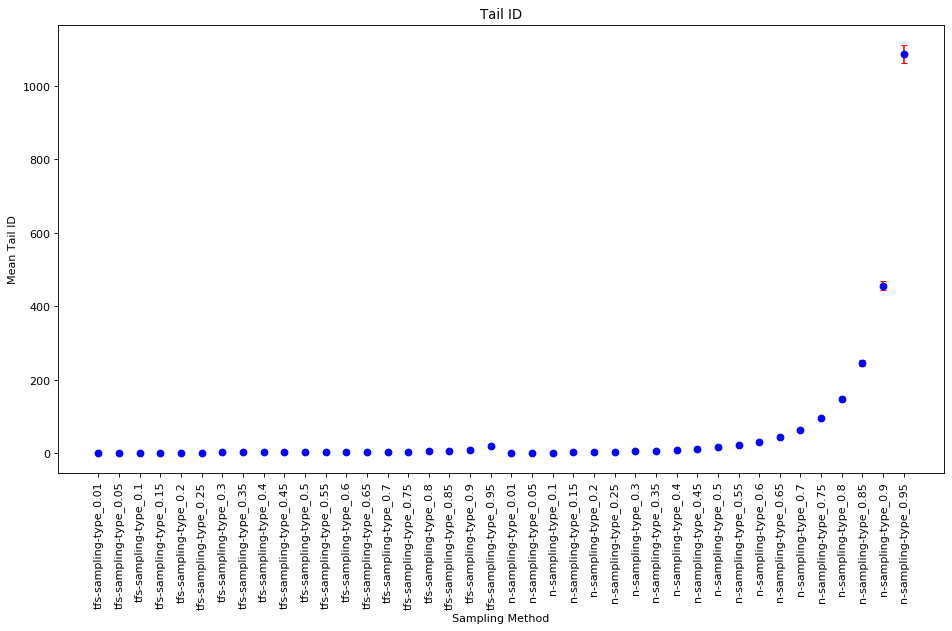

In [60]:
x_pos = np.arange(len(means))
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Mean Tail ID')
plt.xlabel('Sampling Method')
plt.xticks(rotation=90)
plt.title('Tail ID')
plt.tight_layout()
plt.show()

## The mean is tight but is it appropriate?!?!

## Ground Token in Cut? 

Key is: k
k-sampling-type_4_prompt
k-sampling-type_5_prompt
k-sampling-type_6_prompt
k-sampling-type_7_prompt
k-sampling-type_8_prompt
k-sampling-type_9_prompt
k-sampling-type_10_prompt
k-sampling-type_11_prompt
k-sampling-type_12_prompt
k-sampling-type_13_prompt
k-sampling-type_14_prompt
k-sampling-type_15_prompt
k-sampling-type_16_prompt
k-sampling-type_17_prompt
k-sampling-type_18_prompt
k-sampling-type_19_prompt
k-sampling-type_20_prompt
k-sampling-type_21_prompt
k-sampling-type_22_prompt
k-sampling-type_23_prompt
k-sampling-type_24_prompt
k-sampling-type_25_prompt
k-sampling-type_26_prompt
k-sampling-type_27_prompt
k-sampling-type_28_prompt
k-sampling-type_29_prompt
k-sampling-type_30_prompt
k-sampling-type_31_prompt
k-sampling-type_32_prompt
k-sampling-type_33_prompt
k-sampling-type_34_prompt
k-sampling-type_35_prompt
k-sampling-type_36_prompt
k-sampling-type_37_prompt
k-sampling-type_38_prompt
k-sampling-type_39_prompt
k-sampling-type_40_prompt
k-sampling-type_41_prompt
k-sampli

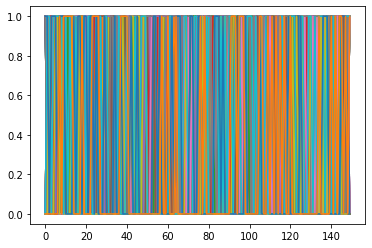

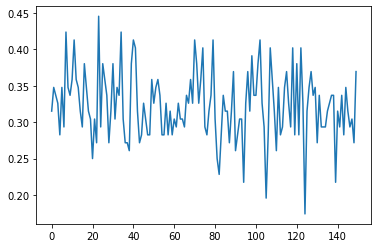

n-sampling-type_0.95_prompt


In [35]:
global_mean = dict()
for key, params in vals_dict.items():
    print('Key is:', key)
    for par in params:
        print(key+'-sampling-type_'+str(par)+'_prompt')
        vals_to_plot = []
        for p_ind in range(tot_num):
            try:
                vals_to_plot.append(ground_token_in_cut[key+'-sampling-type_'+str(par)+'prompt_'+str(p_ind)])
            except:
                pass
                #print('couldnt load in as not here.')
        vals_to_plot = np.asarray(vals_to_plot)
        
        if key == "k" and str(par)=='1':
            plt.plot(vals_to_plot.T)
            plt.show()
            plt.plot(vals_to_plot.mean(axis=0))
            plt.show()
            
        if key == "n" and str(par)=='0.9':
            plt.plot(vals_to_plot.T)
            plt.show()
            plt.plot(vals_to_plot.mean(axis=0))
            plt.show()
        
        global_mean[key+'-sampling-type_'+str(par)+'_prompt'] = (vals_to_plot.mean(), (1.96*(vals_to_plot.std()/np.sqrt(vals_to_plot.shape[0]))))
        print('=======')

# Get for TFS 99%. 

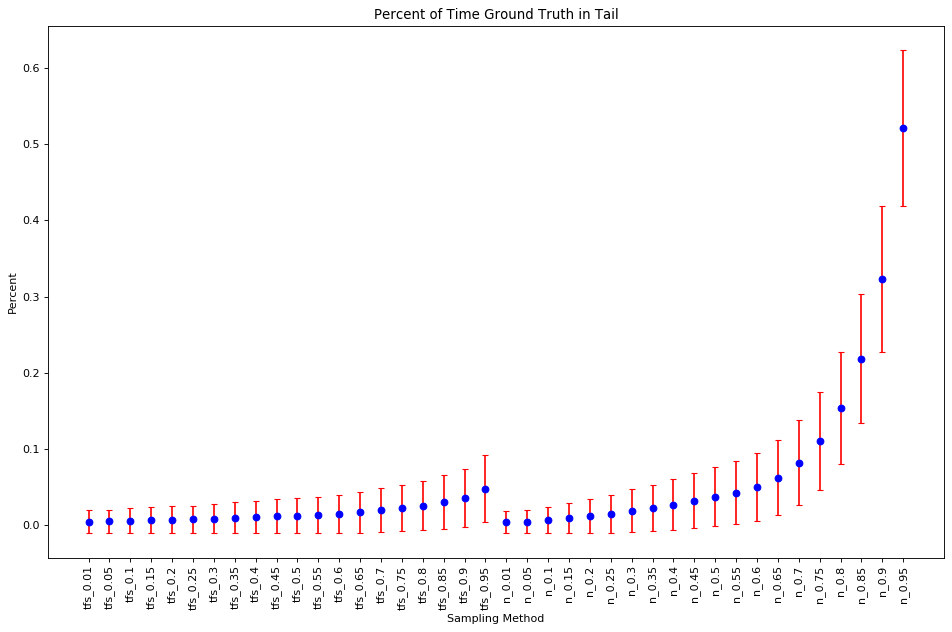

In [44]:
means =[]
errors = []
names = []
for k, v in global_mean.items():
    if 'k-samp' in k or 'flat' in k:
        continue
    means.append(v[0])
    errors.append(v[1])
    names.append(k.split('-')[0]+'_'+k.split('_')[-2])

x_pos = np.arange(len(means))
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(x_pos, means, errors, ecolor='red', fmt='o', capsize=3, color = 'blue')
plt.xticks(x_pos, names)
plt.ylabel('Percent')
plt.xlabel('Sampling Method', size=10)
plt.xticks(rotation=90)
plt.title('Percent of Time Ground Truth in Tail')
plt.tight_layout()
plt.show()